In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pickle
import os
import json
import datetime
import contractions
import pickle
import mysql.connector
from mysql.connector import Error
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, RFE
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 5)
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import sys
# Path to the module (ModelInference) and config
sys.path.append('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src')
from pipeline.modelinference import ModelInference
from config import config

In [3]:
class ToPandasDF():
    def __init__(self, password, host, database, user):

        self.password = password
        self.host = host
        self.database = database
        self.user = user
        
    
    def MySQLconnect(self, query):
        
        try:
            connection = mysql.connector.connect(host=self.host, 
                                                 database=self.database, 
                                                 password=self.password,
                                                 user=self.user)

            if connection.is_connected():

                print("Successfully connected to the database\n")

                cursor = connection.cursor()
                query = query
                cursor.execute(query)

                data = cursor.fetchall()

                df = pd.DataFrame(data, columns = ['id', 'date', 'tweet'])
        except Error as e:
            print(e)
            
        cursor.close()
        connection.close()
        
        return df
    
    def check_if_valid_data(self, data):
        
        # Create a timestamp of the date(Day, Month & Year)
        data['timestamp'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
        
        if data.empty:
            print("No tweets downloaded. Finishing execution")
            
        if data['id'].unique().all():
            pass
        else:
            print(f"Primary Key check is violated, Number of duplicate values: {data.duplicated().sum()}")
            
        if data.isnull().values.any():
            print(f"\nNull values detected, Number of null: \n{data.isnull().sum()}")
        
        yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
        yesterday = yesterday.replace(hour=0, minute=0, second=0, microsecond=0)
        timestamps = data['timestamp'].tolist()
        for timestamp in timestamps:
            if datetime.datetime.strptime(timestamp, '%Y-%m-%d') != yesterday:
                print("Atleast one of the returned tweet does not come from within the last 24 hours")
    
    def pseudo_labelling(self, data):
        
        mi = ModelInference()
        # We made the usernames anonymous in the tweet column
        data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='@user')
        # Script to label new data
        data = data.copy()
        data = data.drop(['date','timestamp'], axis=1)
        data = data.rename(columns={'tweet':'text'})
        if (data is not None):
            # Parse the data through the predicted_output_category & predicted_probability, 
            # which scales and makes predictions
            preds = mi.predicted_output_category(data)
            data['label'] = preds
            data = data[['id', 'text', 'label']]
            print(data.shape)
            
            return data
        


if __name__ == '__main__':
    
    t = ToPandasDF(config.PASSWORD, config.HOST, config.DATABASE, config.USER)
    orig_data = t.MySQLconnect("SELECT id, created_at, tweet FROM `twitterdb`.`twitter_table`;")
    t.check_if_valid_data(orig_data)
    data = t.pseudo_labelling(orig_data)

Successfully connected to the database

Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the retur

# Exploratory Data Analysis & Preprocessing

In [4]:
print(orig_data.shape)
orig_data.head()

(23, 4)


,id,date,tweet,timestamp
0,1545607896393814016,2022-07-09 03:16:53,"@user Ummmm yeah, dude just called half the p...",2022-07-09
1,1546027201983926272,2022-07-10 07:03:03,C$49.99 - #FreeShipping | Best sales in best p...,2022-07-10
2,1546628956647870465,2022-07-11 22:54:12,The full reading on my Instagram: https://t.c...,2022-07-11
3,1546835065581207553,2022-07-12 12:33:13,Off to the springs with Parkers best bud and t...,2022-07-12
4,1547087463960690688,2022-07-13 05:16:09,RT @user: Choose people who choose you.\n\n#ro...,2022-07-13


In [4]:
data.head()

,id,text,label
0,1541844184973320197,There are some exciting changes happening over...,0
1,1541896143445139456,Old wh ite #limpDick men controlling young ute...,0
2,1541916307826028545,My intuition really be scaring me sometimes. I...,0
3,1542127035480285185,hi there!!! cats are feeling excited and calm....,0
4,1542135888766967808,Blog Stagflation requires more than just infla...,0


In [5]:
# These are duplicated rows
data.duplicated().sum()
# # Data with no duplicate
# data=data[~data.duplicated()]

0

# Check the each class

In [6]:
df_hate = data[data.label==1]
print(df_hate.shape)

for i in range(len(df_hate)):
    print('index=', i)
    print('text=', df_hate.iloc[i]['text'])
    print()
    print('label=', df_hate.iloc[i]['label'])
    print()

(336, 3)
index= 0
text= @user @user @user @user @user so guys, what's the point again? My point is that #Russia is not squeaky clean and despite claiming a cleanup of #fascists , they are only projecting what they really are. a Bunch of white russian #supremacists, endorsed by the gov. and promoting the Russian #whitepower. Period

label= 1

index= 1
text= Surprise! how the satanic corporatist #SCOTUS was assembled by the #racist #supremacists of the #fakeSenate, to destroy &amp; reverse any advance in human rights | instead of dealing with the current needs of the people ! https://t.co/yHz9DoiZ3a https://t.co/1hwsOdShEp

label= 1

index= 2
text= @user You are calling a whole Nation #nazis and deny them the right to existence and support because of a few while #Russia is riddled at government level  with white russian #supremacists genociding children and civilians. That's how sick in the head you are. 🤷🏻‍♂️

label= 1

index= 3
text= See, we not satanic #racist #supremacists
We haz pic

index= 97
text= @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user 🤣"SLOW JOE &amp; THE HOE MOVIE TRAILER"🤣

#biden #joebiden #bidenmemes #bidengaffes  #bidendidthat #news  #trump #trump2024 #comedy  #memes #america #liberalworldorder #LWO #nwo #memes #maga #LetsGoBrandon #borisjohnson #uk #bideninflation #FJB #LGB 

https://t.co/0nbfE5I51v

label= 1

index= 98
text= @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user 🤣"SLOW JOE &amp; THE HOE MOVIE TRAILER"🤣

#biden #joebiden #bidenmemes #bidengaffes  #bidendidthat #news  #trump #trump2024 #comedy  #memes #america #liberalworldorder #LWO #nwo #memes #maga #LetsGoBrandon #borisjohnson #uk #bideninflation #FJB #LGB 

https://t.co/0nbfE5ZFT3

label= 1

index= 99
text= RT @user: IMPORTANT message from President Trump! Watch the Video! 🦅🇺🇸💛🌈✨

#NESARA #GESARA #freedom #Love #ULTRAMAGA #Trump http…

label= 1

index= 100
text

text= RT @user: Horny white girl gets mercilessly pounded doggy style by a BBC... She really likes it!!!
#Hardcore #Porn #Sex #Horny #White…

label= 1

index= 238
text= @user What an absolute disgrace this woman is

Britain won't be free until terrible politicians like Truss are removed

#Brexit wasn't done, #mRNA is killing people, and #Ukraine is a Nazi-ridden money-laundering operation

Too many are now awake

She mustn't escape justice

label= 1

index= 239
text= Via @user: Watch: Florida man confronted by beachgoers after he defies rules to stand on protected sea turtle eggs https://t.co/UZfTWVfXvf | #politics #trump #corruption

label= 1

index= 240
text= @user @user @user @user @user @user History will remember #DonaldTrump as the most mentally, emotionally, and politically Damaged #POTUS ever. #Trump makes #Nixon look good. #TrumpOutnixonedNixon #YugelyBadLegacy

label= 1

index= 241
text= RT @user: Via @user: ‘Stranger Things’ spinoff series, stage play are in the works https:

In [7]:
df_non_hate = data[data.label==0]
for i in range(len(df_non_hate)):
    print('index= ',i)
    print('text= ',df_non_hate.iloc[i]['text'])
    print()
    print('label= ', df_non_hate.iloc[i]['label'])
    print()

index=  0
text=  There are some exciting changes happening over the summer break. Tune in to our Hard Hat Reports! #AtlantaInternationalSchool #AISLife https://t.co/QYqSEfrpVn

label=  0

index=  1
text=  Old wh ite #limpDick men controlling young uteruses #limp #limpDicks #MitchMcConnell #limpDickLindsey #oldWhitemen #supremacists https://t.co/7M3yxHYO3E

label=  0

index=  2
text=  My intuition really be scaring me sometimes. I’m like yo, how did I know that 👀✨ #inthefeels

label=  0

index=  3
text=  hi there!!! cats are feeling excited and calm... their plan for today is to meow at the top of their lungs! follow to see daily updates of how cats are feeling and their plans for the day #inthefeels 😾

label=  0

index=  4
text=  Blog Stagflation requires more than just inflation https://t.co/8o5kyTERzi #stagflation #requires #more #than #just

label=  0

index=  5
text=  I just wanna feel🥺 #depressed #longdrives #inthefeels https://t.co/y8XXxdSwWs

label=  0

index=  6
text=  Nine peo

label=  0

index=  71
text=  Angelica! Eliza! #AndPeggy 
The Schuyler sisters!
This is the final week of #Hamilton in #Edmonton.   

Next week #AndPeggy tour moves on to Calgary and #Phillip tour opens in Ottawa!  Hamilton fans, check your tickets and do not miss your performance! https://t.co/OBrVLzZlEF

label=  0

index=  72
text=  Check out this exciting new opportunity to become the next Gérant de territoire (Territory Manager) at Barilla! https://t.co/h4iiFZhCX4 #Montreal #Sales

label=  0

index=  73
text=  @user And will be drafted by Canada's team.. 🇨🇦 
#Habs #Canadiens #montreal

label=  0

index=  74
text=  Find your PERFECT HOME with US!

Book a sneak peek viewing today!
For more information, signup https://t.co/wL3Iio3K2p call +1 587 404 0200

#alberta #realestate #realtor #realestatealberta #edmonton #dreamhome #realtoredmonton #realestateagent #canadarealestate #property https://t.co/ota8AYyDMA

label=  0

index=  75
text=  RT @user: always swallow everything #porn #nsfw 

label=  0

index=  140
text=  Wow, it's all happening at number 10 tonight!! #government #UKgovernment #politics

label=  0

index=  141
text=  RT @user: https://t.co/QsAvYLXLLi

When #RuleOfLaw fades into the background
- #Truth goes out the window
- #HumanRights &amp; human life d…

label=  0

index=  142
text=  RT @user: ... That's it all it takes, a simple little twist of fate
A little spark, some strength to keep your heart from breakin'...…

label=  0

index=  143
text=  RT @user: In 1999 and 23 Years Ago, #Passions premiered on @user on this day and here's hoping there be a revival in the future or it b…

label=  0

index=  144
text=  RT @user: You haven't heard this music podcast with Special guest @user

Music from
@user
@user
@user…

label=  0

index=  145
text=  RT @user: In 1999 and 23 Years Ago, #Passions premiered on @user on this day and here's hoping there be a revival in the future or it b…

label=  0

index=  146
text=  By the way it's July 5th...Happy #Passions Day!!

label=  0

index=  188
text=  RT @user: Vice chair of UK Conservative Party resigns, calls for Boris Johnson to stand down – by @user

https://t.co/JqIvfi9BLm…

label=  0

index=  189
text=  RT @user: Daily sound design 133
.⁠
#composer #sounddesign #cinematicsound #filmcomposer #mediacomposer #basssound #dailysound #ableton…

label=  0

index=  190
text=  RT @user: We need to remember that @user got us through Covid and now the Ukraine War. He’s been an excellent PM. If Labour ge…

label=  0

index=  191
text=  RT @user: "Enter Wishin’ - i’Ye Deux" by Jae SatelliTe🛰 #nowplaying #soundcloud #lofimusic #electronicmusic #alternative #hiphop #i…

label=  0

index=  192
text=  RT @user: On this day in 1999, #Passions premiered with this episode of #Days as the lead in. The beginning of John and Marlena’s…

label=  0

index=  193
text=  RT @user: In 1999 and 23 Years Ago, #Passions premiered on @user on this day and here's hoping there be a revival in the future or it b…

label=  0

index= 

label=  0

index=  296
text=  What continues to baffle me is that #Trump pushed to have vaccines authorized and yet no Republican's blame him for his part in this mess. #Pfizer 

https://t.co/7D60z5WVNd

label=  0

index=  297
text=  RT @user: @user Andrew Bridgen on #Brexit "You can't have another vote because you didn't like the result."

Andrew Bridgen on #Bor…

label=  0

index=  298
text=  RT @user: U.S. commentator slammed for suggesting that Toronto is a bad city for Black athletes https://t.co/PhEyfzzg9F #Toronto

label=  0

index=  299
text=  RT @user: “Tactically and ethically, #Starmer’s got #Brexit wrong” 
https://t.co/1yOCAah3Mc

label=  0

index=  300
text=  RT @user: HAS PARIS BEEN STOLEN? She was last seen when someone took her into their BMW. 

Female #FrenchBulldog 
#Edmonton #London, N9…

label=  0

index=  301
text=  RT @user: #BLACKPINK, a top #Kpop girl group, will make a long-awaited #comeback in August. It did not give details of the upcomi…

label=  0

index=  


label=  0

index=  360
text=  #music thank you who ever sent me CD get well gifts. Thank you ❤️❤️ https://t.co/YVNb8xU1Lb

label=  0

index=  361
text=  Polish government approves bill to sell Russian-controlled firms https://t.co/VIkHQS0PZP #Politics https://t.co/eQQT8822Zi #news 53

label=  0

index=  362
text=  Meryl Streep's Feminist Roles Foreshadowed Current #Politics - National Review https://t.co/e8bY61NWTG

label=  0

index=  363
text=  White Clean Plexus Background Pack V3
https://t.co/sw5YQOzWP4

#abstract #background #backgrounds #clean #connection #corporate #elegance #elegant #graysolid #lines #loop #motiongraphics #plexus #polygon #simple #smooth #triangle #videohive #white https://t.co/BQCH0ed5bm

label=  0

index=  364
text=  RT @user: HAPPY WEDNESDAY GET TOGETHER
#BLM #Buffalo #Texas #Ohio #Chicago #BlackLivesMatter
SUPPORT
#DemVoice1 #VoteBlue2022 🇺🇸 
#…

label=  0

index=  365
text=  The latest The NCAA March Madness (CBS/Turner) Daily! https://t.co/Kono3v2TbV Than

text=  RT @user: Oh #Canada  😯 .. You must Wake Up! .. Think before You Vote! 

It Won’t be YOU that Benefits 🤷🏼‍♀️ Should You make the Wr…

label=  0

index=  454
text=  RT @user: See the artistic nude pics of Bernard by subscribing at https://t.co/2QS4zTBsKf

#vancouver #edmonton #winnipeg #saskato…

label=  0

index=  455
text=  RT @user: oh she riding riding #bbw #bbc #car #nsfw #swallow #slut #thot #public #shower #horny #sneakylink #amateur #homemade #onlyf…

label=  0

index=  456
text=  RT @user: Ebony bend over 🍑🍆💦😈 #big #fat #dmvfreaks #deep #nakedattraction #juicy #xxx #porn #ebonywoman #cumchallenge #Homemade…

label=  0

index=  457
text=  RT @user: National @user ends her address to the #AFN General Assembly by saying “I am a warrior for peace. I am a warri…

label=  0

index=  458
text=  RT @user: Show Alert! PACIFIC NORTHWEST!! See you soon! @user and I are coming to #Portland, #Seattle, #Vancouver! Grab tix n…

label=  0

index=  459
text=  RT @user: Fucking her throat

index=  506
text=  I’m going to @user’s upcoming Space. Will you join too?
#Bitcoin #Independence #Politics

https://t.co/Kd0lvg8MND

label=  0

index=  507
text=  MaggieB today (Wednesday): https://t.co/7S7eCwAWLC
#blm #LGBT #AOC #democracy #bluewave2022 #Socialism2021 #model #AbortionIsEssential #TransAwarenessWeek #antifascist #Chicago #Hiring #HIRINGNOW #DemocracyNotAutocracy  #AbortionIsHealthcare #Communist #communismwork https://t.co/RI1kJnX4a0

label=  0

index=  508
text=  RT @user: If most doctors had the courage of truckers, this political catastrophe would be over. @user @user @user #Bi…

label=  0

index=  509
text=  RT @user: Here is what you need to know. Forget what the polls say. Forget what the media outlets say. The power is with the peopl…

label=  0

index=  510
text=  RT @user: Here is what you need to know. Forget what the polls say. Forget what the media outlets say. The power is with the peopl…

label=  0

index=  511
text=  Consider these sets:

- #Religious #

text=  RT @user: There's angry squirrels on the morning pottywalk in #Edmonton so guard your treats. ☁️ &amp; a high of 21°C with lots of mu…

label=  0

index=  593
text=  00:00 Temp 14.6°C, Feels Like 14.6°C, Humidity 84%, Precipitation Today 0.00 mm, Precipitation Duration 0 Minutes, Wind Avg 4.7 km/h, Wind Gusts 8.6 km/h, Wind Directions 144°, UV 0.0. #yegweather #edmonton #yeg

label=  0

index=  594
text=  00:00 Temp 14.8°C, Feels Like 14.8°C, Humidity 85%, Precipitation Today 0.12 mm, Precipitation Duration 18 Minutes, Wind Avg 1.4 km/h, Wind Gusts 4.3 km/h, Wind Directions 87°, UV 0.01. #yegweather #edmonton #yeg

label=  0

index=  595
text=  Where once stood Dutch Maid Ice Cream: Osborne Street at Gertrude Avenue #Winnipeg Manitoba, Canada. /
@user @user @user @user @user https://t.co/h65TyHu0KS

label=  0

index=  596
text=  RT @user: JUST ANNOUNCED: I'm excited to be heading to Calgary on August 12th at @user with @user !

@user and @…

label=  0

index=  597
text=  RT @use

label=  0

index=  659
text=  RT @user: 💖🇨🇦 
Fairmont Waterfront Vancouver
@user
Relax into West Coast luxury and explore Vancouver with us #FairmontWat…

label=  0

index=  660
text=  RT @user: .@user to skip #Calgary leadership debate, will attend party with Nut Job Brett Wilson.
He is flat out afrai…

label=  0

index=  661
text=  RT @user: Waterfront property goals in beautiful #Belcarra 🚁 #Vancouver #Canada #YVR #helicopterlife https://t.co/4fe1y97tZE

label=  0

index=  662
text=  Lean muscular men await you at https://t.co/M0CpIy2kT5.  Join now!
#ottawa #edmonton #calgary #winnipeg #vancouver #quebeccity #montreal https://t.co/WnOytUOFkP

label=  0

index=  663
text=  Giddy Up #Calgary 
First #Stampede breakfast today.
Boots and buckle!
#AlbertaBoot #OlsonSilverCompany
#OOHAY in #yyc https://t.co/DG9r24MFO3

label=  0

index=  664
text=  RT @user: After #Nairobi 🇰🇪 what's needed until #COP15 in #Montreal 🇨🇦 for the Global Biodiversity Framework to be tranformative eno…

label=  

label=  0

index=  725
text=  RT @user: Onee-chan pussy is the best, she let me to use her pussy for training. But i think she likes it.

#Shota #Cunny #Loli #G…

label=  0

index=  726
text=  06:00 Temp 15.0°C, Feels Like 15.0°C, Humidity 84%, Precipitation Today 0.00 mm, Precipitation Duration 0 Minutes, Wind Avg 5.8 km/h, Wind Gusts 14.4 km/h, Wind Directions 153°, UV 0.15. #yegweather #edmonton #yeg

label=  0

index=  727
text=  RT @user: A big welcome to everyone visiting Montréal for the 2022 #NHLDraft — history will be made today! 🎉

📷 @user @user @user…

label=  0

index=  728
text=  Passionate about making an impact? A new position as HR Recruitment &amp; Retention Administrative Specialist recently opened in our Montreal, CA location! https://t.co/W2c5UHHjDN #HumanResources #Montreal

label=  0

index=  729
text=  Now live @user Culture &amp; KVSH - Descontrol   https://t.co/8iI74xa29U #houselovers #fm #love #house #radio #house #techno #deep

label=  0

index=  730
text=  #

label=  0

index=  774
text=  [#SUSTAINABLE COMMUNITY] A unique way to encourage and support #gardening and #greening in the #community 🌻 Inspired to start something similar in your city? 🦋  #EarthDayCanada #Calgary 
https://t.co/OxF7frNsnS

label=  0

index=  775
text=  RT @user: Canadians are now only starting to see liberal fiscal incompetence….record insolvencies, record inflation, record high t…

label=  0

index=  776
text=  RT @user: Excited to share the latest addition to my #etsy shop: Natural 4.50ctw Opal &amp; Diamond Black Rhodium over .925 Sterling Silver…

label=  0

index=  777
text=  RT @user: Excited to share the latest addition to my #etsy shop: Natural Ethiopian Opal .925 Sterling Silver Ring Size 8, 1.9g https://t…

label=  0

index=  778
text=  Today is the day. #GoHabsGo #nhldraft2022 #Montreal #ShaneWright https://t.co/6e7Ss6k3nG

label=  0

index=  779
text=  RT @user: Look deep into nature, and then you will understand everything better.

#AlbertEinstein
#goodm


label=  0

index=  855
text=  What are you willing to fight for? #Psychology #Acoustics #Physics #Neurology #Crime #Police #blm #Bighouse https://t.co/CYUUObsruu

label=  0

index=  856
text=  If you were streaming https://t.co/gQEZOjVGLt right now you’d hear Rainbow (1977) by Teruo Nakamura And The Rising Sun and that would make things slightly better. Free internet jazz radio #history #jazz #coffee #art #montreal #toronto #guitar #trumpet #sax https://t.co/yRquERzcqY

label=  0

index=  857
text=  07:00 Temp 15.6°C, Feels Like 15.6°C, Humidity 82%, Precipitation Today 0.00 mm, Precipitation Duration 0 Minutes, Wind Avg 8.6 km/h, Wind Gusts 11.5 km/h, Wind Directions 125°, UV 0.47. #yegweather #edmonton #yeg

label=  0

index=  858
text=  07:00 Temp 15.3°C, Feels Like 15.3°C, Humidity 85%, Precipitation Today 0.00 mm, Precipitation Duration 0 Minutes, Wind Avg 4.3 km/h, Wind Gusts 7.6 km/h, Wind Directions 103°, UV 0.23. #yegweather #edmonton #yeg

label=  0

index=  859
text=  RT @u

label=  0

index=  901
text=  @user It's like looking at a menu and trying to pick the least unappetising option. #UK #politics #Toryleadership

label=  0

index=  902
text=  RT @user: HAPPY THURSDAY GET TOGETHER
#BLM #Buffalo #Texas #Ohio #Chicago #BlackLivesMatter
SUPPORT
#DemVoice1 #VoteBlue2022 🇺🇸 
#B…

label=  0

index=  903
text=  RT @user: Via @user: Pennsylvania Dem to get 'wave of Republican endorsements' as GOP fractures over gubernatorial nominee htt…

label=  0

index=  904
text=  RT @user: Photos of some of the riot arrestees from the Akron, Ohio #BLM riot late on July 3. Rioters started fires &amp; smashed up prope…

label=  0

index=  905
text=  The #EarshotSongOfTheDay is Max Hopkins' 'The Thousand Year Journey'. The #Calgary singer-songwriter exploits 5/4 time to anthemic results in this folk-rock track about remaining open to the world &amp; ourselves.

More: https://t.co/cJdt8Fy4On
#earshotdistro #musicdistro https://t.co/EYblTFfenB

label=  0

index=  906
text=  RT 

label=  0

index=  995
text=  #BorisJohnson was the #ERG's puppet to 'get #Brexit done'.  He served his purpose although it took longer to get rid of him than they would have liked.  Their next pick will be a Brexit fanatic they think will deliver their 'Pure' Brexit.

label=  0

index=  996
text=  RT @user: Many of my friends hated Boris Johnson for his role in #Brexit. Quite frankly, I disliked him for that too. But my God, h…

label=  0

index=  997
text=  RT @user: More amazing sponsors that we need to thank! 
⁠
Buy your festival tickets today!
https://t.co/bCSWPh7W0u
⁠
#webseries #festi…

label=  0

index=  998
text=  RT @user: I'm seeing huge public support still for @user 

May had none of this.

We #BackBoris The PM of the people and #brex…

label=  0

index=  999
text=  Music for programming https://t.co/hFMY5Wu2sJ

#gamedev #gamedevelopment #indiedev #programming  #music https://t.co/wdjwJPoioj

label=  0

index=  1000
text=  RT @user: Photos of some of the riot arrestees fro

label=  0

index=  1047
text=  RT @user: July 7, 1977 Styx released their 7th studio album, 'The Grand Illusion'. #Music https://t.co/Y9bMvDb9pa

label=  0

index=  1048
text=  RT @user: 🎙️ New podcast episode is out!!

Dr. Ryan Yonk joins @user on Liberty Curious to discuss #PublicChoice theory, which  #JamesB…

label=  0

index=  1049
text=  RT @user: Have an amazing Thursday! Be FIERCE!!! 🤘❤️🔥
.
.
.
.
#GoldyLocks #GoldylockSBand #Music #Love #GoldyLocksRocks #GoldyKn…

label=  0

index=  1050
text=  Democrats Turn On Biden’s "Dictator Rule"  #MAGA #TRUMP2024 #Trump

https://t.co/B71RGMNKzx

label=  0

index=  1051
text=  A new piece on the drawing board, back to the musician theme 😀🎶 #sax #saxophone #musician #jazz #music #livemusic #livemusicart #draw #drawing #buyoriginalart #openforcommissions #commissionsopen #originalartwork #originalart #band #maws #mawscraftcentre #mawscreatives https://t.co/eIcCOIvq3d

label=  0

index=  1052
text=  RT @user: TONIGHT'S THE NIGHT!

The Absolu

text=  Black tights and white socks #Black #tights #and #white #socks #Blackpantyhoseandwhitesocks https://t.co/sLQmzhlTtn

label=  0

index=  1139
text=  RT @user: Hello #canada 🇨🇦, I'm gorgeous little girl, looking for #foster home in #toronto or surrounding. Mom rescued me from dog…

label=  0

index=  1140
text=  Crown PCC-160 Phase Coherent Boundary Mic Working with No Cable https://t.co/rab5syKwkA - #music #producers  #rock #soulmusic #funk

label=  0

index=  1141
text=  RT @user: #NowPlaying 🎶🎵 On 🐦@user : 
🎶📀🎶🎵 Ayane Yamazaki 🇯🇵
🎶Sweet Planet 🎶 
🐦 @user

#TuneIn📡 🌍🌏https://t.co/kSaWxc9x8T 👀 SUP…

label=  0

index=  1142
text=  RT @user: Its my bro Danny Rebels bday today. Facebook suggested this pic for his bday. With Brian @user , Danny, @user @user…

label=  0

index=  1143
text=  RT @user: Personal beliefs are so powerful, that it can make an elephant act like a sheep in the presence of a lion.

#Leadership #L…

label=  0

index=  1144
text=  RT @user: https://t.co/mSWW7U9X

text=  RT @user: You can't just "make Brexit work", @user, when it’s clearly doing such damage

Pretending #Brexit can be positiv…

label=  0

index=  1207
text=  RT @user: @user 😡No apology. For all the #brexit lies. For all the people who died of #covid. For all the civil servants…

label=  0

index=  1208
text=  RT @user: Via @user: 'Reclusive and unpleasant' Ron DeSantis looks like the heir to Richard Nixon: columnist https://t.co/yBdR…

label=  0

index=  1209
text=  RT @user: #Boris forced out by left wing media. Just like #Trump. Democracy is dead.

label=  0

index=  1210
text=  RT @user: Many of my friends hated Boris Johnson for his role in #Brexit. Quite frankly, I disliked him for that too. But my God, h…

label=  0

index=  1211
text=  @user Aunt Tiffa - I GET BLAMED FOR everything! Antifa
@user
I am unable to FB at this time
(Democrat) Louisiana GREAT GRANDMAW 
#tRump4PRISON
#GunReform    
#BLM 
#ProCHOICE

label=  0

index=  1212
text=  RT @user: @user Canada, Netherland

text=  RT @user: The Clock Tower turns 100—my look back as this #Montreal icon marks its centennial 🕒 https://t.co/OCwca5qA7j via @user…

label=  0

index=  1276
text=  @user To be fair, I think we knew what they are before they got elected.

The problem is those that want nothing more that to blame Johnson and rush back to the Tories, of which there are many, and they won't take much persuading with the mention of #Brexit here and immigrants there...

label=  0

index=  1277
text=  RT @user: many promotion video there!
please visit to it🥰

👉 https://t.co/rU15CxWFrx

#instagram #promotionvideo 
#musicvideo #mus…

label=  0

index=  1278
text=  @user @user History will remember #DonaldTrump as the most mentally, emotionally, and politically Damaged #POTUS ever. #Trump makes #Nixon look good. #TrumpOutnixonedNixon.

label=  0

index=  1279
text=  @user Before #Brexit Stormont worked, there was no talk of a united Ireland and Northern Ireland was moving forward as was the rest of the UK.


label=  0

index=  1354
text=  RT @user: Deepthroat Training🔥🔥💦
#Blowjob #Facefuck #Deepthroat #Throated #Deep #Throatfucking #Head #Cum #Cumshot #Facial #Teen #Blo…

label=  0

index=  1355
text=  Released on the 25th of June, just over 4 months after his last notable single, "Best In Me" is the latest record by Johannesbu... https://t.co/ojthFRzUQ8 #musicreviews #skunkradiolive #music https://t.co/1zIcU3fdBx

label=  0

index=  1356
text=  RT @user: Hey #Winnipeg I have a buddy looking to sell their Folk Fest camping ticket, interested?

label=  0

index=  1357
text=  RT @user: #Labour centrists enabled Johnson's victory and a hard #Brexit
Shame on them. 
#FordeReport

label=  0

index=  1358
text=  RT @user: "Dick goes deep in, Tears comes out"🔥🔥🔥💦
#Blowjob #BBC #BBCSlut #Facefuck #Deepthroat #Throated #Deep #Throatfucking #Head…

label=  0

index=  1359
text=  Excited to share the latest addition to my #etsy shop: Evil Eye Protection Rear View Mirror Charm Nazar Mirror Amulet Talis

text=  RT @user: @user @user #THIEF plans2take legally owned guns from responsible citizens but what will he do about the mi…

label=  0

index=  1421
text=  When did it become okay for the cops to do whatever they want especially while off duty? They are not the military. #blm #brownlivesmatter #racialism #youngbrownlivesmatter https://t.co/jKagphplfE

label=  0

index=  1422
text=  Who’s registered for the #toronto #rgd #designthinkers conference? Im seriously considering it as it’s been a long time for a creative injection.

label=  0

index=  1423
text=  Downtown #boston provides wayfinding for people. Downtown #winnipeg has wayfinding for cars. One city has an abundance of pedestrians &amp; one city has several surface parking lots. https://t.co/j3uEOrkoDO

label=  0

index=  1424
text=  You want him to spread it wider, don't you? Go on and have fun with the boys at https://t.co/2QS4zTjRlF!  Subscribe now!

#vancouver #montreal #toronto #quebeccity #ottawa #calgary #winnipeg https

index=  1492
text=  @user @user Tell that to black people. And you have #BLM in your bio. Get a fucking clue lmao 🤣

label=  0

index=  1493
text=  Jordyn Woods and Karl-Anthony Towns Visit the White House to Support Police Reform #bitcoin #Jordyn #Woods #KarlAnthony #Towns #Visit #White #House #Support #Police #Reform https://t.co/KCHTb4V64P

label=  0

index=  1494
text=  Reposted from @user The Beautiful Red White and Blue
#4thofjuly #red #white #blueface https://t.co/y7CdBBJCRA

label=  0

index=  1495
text=  RT @user: Boris Johnson's departure as prime minister can lead to a more "constructive" and "respectful" relationship between Bri…

label=  0

index=  1496
text=  RT @user: A Phat Wet Pussy + A Sexy Moan Is What I Love 😈😈😈

#adultcontent #bbc #deep #bigdick #cuminsideher #EbonybbwBackShot #freak…

label=  0

index=  1497
text=  RT @user: Brother forces sister to jack him off #incestteens #incest #stepsister #sisterbrother #white #pyt #handjob https://t.co/VZN…

label=  0

inde

label=  0

index=  1579
text=  Agama Label Fit Alert! 🔥

Match these Agama Label hoodies with our new Black Womens Leggings. 💯

Shop now at https://t.co/gbnitZLNXO

Limited quantity available.

#AgamaLabel #ForHer #RockYourConfidence #RYC #leggings #Highend #Fashion #torontobusiness #TO #toronto #Canada https://t.co/foKKquTpy9

label=  0

index=  1580
text=  RT @user: White House Press Secretary Appears Blindsided by Report US is Selling Emergency Oil Reserves That are Going to China http…

label=  0

index=  1581
text=  RT @user: @user @user @user @user @user @user @user My daughters are trans and…

label=  0

index=  1582
text=  #NowPlaying Loretta Lynn, Conway Twitty - You're The Reason Our Kids Are Ugly - Single Version - The Eighth Room streaming live 24/7-365! https://t.co/2mfBngB8Og #nashville #music #lounge

label=  0

index=  1583
text=  RT @user: @user 2025 … is still a long way! .. should you make it there .. in Politics! .. For you to make the difference?…

label=  0

index

index=  1649
text=  RT @user: Well... Who were her clients? #childtrafficking #maxwell #Epstein #EpsteinIsland #GhislaineMaxwell #america #Politics #se…

label=  0

index=  1650
text=  Funny how @user can’t answer what part of #brexit has been delivered and gets offended very easily. A government run for years wso the rich get richer &amp; people can’t afford the basics to live. That’s what offensive. The lies started with Brexit #liars #GetTheToriesOut https://t.co/L0ed4toJy2

label=  0

index=  1651
text=  RT @user: Eat Clean🍑💨 #Vegan #EatClean #Nsfwtwt #Toronto #nsfw #lewd #horny #fartgirl #findom #Canada https://t.co/J5Z2lOtigd

label=  0

index=  1652
text=  RT @user: If you haven’t purchased your tickets for the 2022 #TriHospital Dream Lottery, this is the absolute final day to do so.…

label=  0

index=  1653
text=  RT @user: Only the British people can hold #Johnson to account. 
Whatever happens next, the EU must insist on the full implementati…

label=  0

index=  1654
text=  

text=  #Vancouver - Crews on scene to a crash on Oak St northbound at 33rd Ave https://t.co/gCRXAEGd9U

label=  0

index=  1723
text=  RT @user: @user John ‘Family Values’ Major still embittered over #Brexit continues with his vendetta against #Boris . Not con…

label=  0

index=  1724
text=  RT @user: #hornypower I need my clit sucked!
.
#clitrubbing #clitrub #clitsucking #deep #raw #tinder #Onlyfansdiscount #SellingContent…

label=  0

index=  1725
text=  #Saskatchewan ranchers have a beef with the meat packers - #news #canada #beef #ranchers #Sask #sk #prairie #prairies #politics #government #cdnpoli #saskpoli #skpoli #economy #business #trade #inflation #costofliving #costoflivingcrisis https://t.co/JNQymISfxm

label=  0

index=  1726
text=  -Hear #StevaniaMinistries' #ILoveYou &amp; #IConsecrate in #MusicLov3rzRadio's 8:30-10:30PM EST rotation at  https://t.co/UiuPc56ASO #MusicLov3rz 24/7 #independent #Christian #Gospel #Music   https://t.co/R63tSoeLWr

label=  0

index=  1727
tex

index=  1777
text=  @user @user Hi Elon! 
I wrote a song about you. 
I hope you enjoy it. 🚀🙏👇🏼 
#ElonMusk #ElonSpaceX #Mindyou #ElonMuskmindyou  #elonmusktwitter #ElonMuskTesla #Tesla #TeslaModel3 #TeslamodelX #ELON100M #verald #hiphoprap #music #deephouseradio #ThorLoveAndThunder
https://t.co/z9tn9E0mhD

label=  0

index=  1778
text=  #UK should join the #EuropeanUnion.... #Brexit was the worst decision by the Tories.

label=  0

index=  1779
text=  https://t.co/D7Ad1Y18CT🧨

Shop  HB SLIDES in 3 different color-ways of our signature colors- 😍🖤🤞🏽🤍 #comfy #quality #slides #black #white #mixedmatch #heartblaster #friends #juniors #adult #sizes #goodpeople 

📸 @user https://t.co/L90HfYKjpl

label=  0

index=  1780
text=  RT @user: Dinner and dessert in #Kerrisdale on Monday night.  LXY Hunan Fusion followed by BlackBall Dessert.  #yumyum

#Vancouver h…

label=  0

index=  1781
text=  https://t.co/TOqkVEAwhI what would @user know about honesty? She LIED. And Lied and lied. Claimed "#Brexit


index=  1837
text=  RT @user: The Irish gov stands ready to work with a new U.K. PM on protecting our shared achievements in the peace process &amp; our sh…

label=  0

index=  1838
text=  Please Ignore This !!! - We've Had ENOUGH #Canada #Ottawa #Toronto #Montreal #Halifax #Calgary #Vancouver https://t.co/M5dNlEVz7B

label=  0

index=  1839
text=  Today!! #NHLDraft #Montreal https://t.co/Rn7J1M7At6

label=  0

index=  1840
text=  RT @user: online services &amp; meet ups available!! all link(s) in bio #winnipeg #contentcreator #meetups #onlyfans #sw #nsfwtwt #nsfw…

label=  0

index=  1841
text=  RT @user: @user @user @user @user @user @user @user 🔴🇬🇧 As the situation unravels…

label=  0

index=  1842
text=  Calgary! 📣 @user &amp; @user are bringing the Jinkx &amp; DeLa Holiday Show to @user on December 29th!🎄 Tickets go on-sale at 11am MT 
Ticket link: https://t.co/w3LYd7ugvS 🎟
#jinkxanddela #jinkxmonsoon #bendelacreme #rupaulsdragrace #calgary #calgaryevents #yyc https://t.co/Qv6jb


label=  0

index=  1907
text=  The #modernwhiteboi sad lil limp clit on her knees ready to serve the BNWO ♠️🖤 
#BNWO #BBC #Interracial #WhiteGenocide #WhiteExtinction #WhiteSlavery #BlackOwned #RefugeesWelcome #BLM #Whiteboys #Blacked #BlackPower #QoS #Snowbunny #Pussyfree #snowbunny #sissy #saynotowhiteboys https://t.co/mGyIYNF3aN

label=  0

index=  1908
text=  Now playing on Cool Deep: SlyFox (Original Mix) by The Watsons! Tune in now.
https://t.co/7J9MKGrZqT
#deep #deepmusic #deephouseradio #deephouse #deephousemusic #cooldeep #balearic #balearicgroove #balearicradio

label=  0

index=  1909
text=  Chulbul Pandey, Not Salman Khan Makes Debut As BollyCoin’s NFT Collection; Bitcoin Rises - https://t.co/vsOfrEqOOc - #nft #nfts #art #artwork #artist #music #photo #creative https://t.co/KaJDuS6IWf

label=  0

index=  1910
text=  RT @user: TRAFFIC UPDATE:
SB EMPRESS ST. CLOSURE
Southbound Empress Street, from Saskatchewan Avenue to Wellington Avenue, is closed…

label=  0

index=  1911


label=  0

index=  1982
text=  RT @user: ⠀ ⠀⠀
                   ‘ D E E P ’  IS OUT NOW !

YOUTUBE: https://t.co/cRMG5jjWeL
SPOTIFY: https://t.co/mGtZKZMjZV…

label=  0

index=  1983
text=  Seems like the implementer of #Brexit can't bring himself to exit as quickly as he should. @user #BritishTrump https://t.co/1px00ttIi2

label=  0

index=  1984
text=  @user #BREXIT... and Congratulations to you and your team's efforts for almost single-handedly bringing down the Conservative Party. #WELLDONE 👏👏👏🌐🗽@user @user @user

label=  0

index=  1985
text=  Right, whose the next Tory idiot who’s gunna be taking over? #ResignationWatch #politics #BorisResigns

label=  0

index=  1986
text=  New releases on studio vibes turned up LISTEN NOW #Infinity Mixed by #deep #soulfulhouse  brighterdays Subscribe | Like | Share | Dance Enjoy! Promoted https://t.co/GPRRfHu6im 15:45:28 plz #RT https://t.co/rZgTmukO6U

label=  0

index=  1987
text=  RT @user: Hey @user &amp; @user how come I haven’t heard @us


label=  0

index=  2035
text=  Warren, Sanders Call on Biden to Issue Pardons for Cannabis-Related... (Truthout)

A group of six Democratic senators sent a letter to President Joe Biden on Wednesday, asking...

Add your highlights:
https://t.co/MS6myw2Zdt
 #LeftWing #Politics...

label=  0

index=  2036
text=  RT @user: FLY AWAY reaction video out NOW! Link in my Bio.

S/O @user &amp; the squad at
@user 
@user

#flya…

label=  0

index=  2037
text=  RT @user: Heads-up #conservatives and #constitutionalists! @user #Teachers in #MN #schools must have a #Marxist #worldview…

label=  0

index=  2038
text=  RT @user: Overall, do you think Boris Johnson has been…? #BorisJohnson #PrimeMinister #Politics #Poll

label=  0

index=  2039
text=  RT @user: #Brexit 2096 Femi Oluwole still talking about Brexit. 👍 https://t.co/kC3mKWmwwR

label=  0

index=  2040
text=  RT @user: #Vancouver's mouthwatering Cheese and Meat Festival to return this fall 🍖🧀 https://t.co/rFbn7VJ3KA

label=  0

index=  2041

text=  Canada's jobs market is setting records. So why are people talking about a recession?  https://t.co/os69Ft7b1z 

#cdnbiz #innovation #canada #fintech #cdnpoli #business #montreal #startup #toronto #smallbusinessbc #sbbc #bcbusiness #vancouverbusiness #Growth500 https://t.co/jtjZJ2L2IQ

label=  0

index=  2112
text=  RT @user: MP @user, you said: "the position of the CPC ... we need not be pouring fuel on the fire" of extremism.
But Pier…

label=  0

index=  2113
text=  RT @user: Next Wednesday at the Just Jazz Live Concert Series. Hit the link in the bio for tickets! #justjazzlosangeles #brandoncol…

label=  0

index=  2114
text=  @user is coming to MacEwan Hall this Saturday, July 9. Get your tickets here: https://t.co/4XY3bXB3Tz
#mirandasings #calgary #yyccomedy #yyc #yycevents #yycliving #yycconcerts #machall #macewanhall #CalgaryArts https://t.co/hsptkdtA0s

label=  0

index=  2115
text=  What can sellers do in the current market?
https://t.co/jkVulJe95v
#Family #Mississauga

label=  0

index=  2169
text=  Why Does Proper Marketing Sell Homes So Much Higher and Faster in Vancouver?  
Get your FREE digital copy of my book "Secrets Every Seller Needs To Know"  https://t.co/hbmlUwF8EQ  
#realtor #realestateagent #vancouver https://t.co/XtxdZswQ0t

label=  0

index=  2170
text=  @user is #Hiring
MEET THEM FACE-TO-FACE &amp; BRING YOUR RESUME
Do Not Miss! #Calgary #InPersonJobFair
Thursday, July 28th, 2022, 1PM-4PM
Radisson Hotel, 6620 36th. Street NE, Calgary. AB. T3J4C8
REGISTER NOW: https://t.co/0kagBwqSIQ  FREE TO ATTEND https://t.co/6jLZtHMgXD

label=  0

index=  2171
text=  RT @user: She likes to be slammed like this!!!
#Hardcore #Porn #Sex #Hot #Girl #Ficked #Hard #Slammed #Deep #Banged #Rough #Big #Cock…

label=  0

index=  2172
text=  RT @user: She is an object for his use. and she loves it.

#BNWO ✊🏿✊🏿✊🏿 

#blm #nbwo #whitegenocide #whiteboy #whiteboi #sissy #twi…

label=  0

index=  2173
text=  @user @user @user @user History will remember #DonaldTrum

index=  2213
text=  White people trying to stay relevant in society.  I don't claim you.  Your like that ass kisser 💋er no one likes at work.  #white #Liberals #LiberalismIsAMentalDisease #itshappening #USA

label=  0

index=  2214
text=  Throwback to 2017 and drier, sunnier start to the #Vancouver commute. 

#ThrowbackThursday #SeenOnMyCommute #Vancouver #BlackAndWhite https://t.co/IdpKH9f4wv

label=  0

index=  2215
text=  RT @user: Submit your Modern Soulful Music Awards nominations today! #musicallysoulful

#SubmitYourMusic #ModernSoulfulMusic #Musi…

label=  0

index=  2216
text=  RT @user: 3/ Among Dr. @user's numerous articles and reports, we highly recommend her book, Uncivil Agreement: How Polit…

label=  0

index=  2217
text=  A huge $10,000 price improvement was just made on our spacious, contemporary open concept condo just minutes from Downtown Calgary in the heart of trendy Crescent Heights!

https://t.co/Oua9OmHqAQ

#YYC #YYCre #CrescentHeights #Calgary https://t.co/GvhD

label=  0

index=  2274
text=  RT @user: Here is a video clip of ''Alpha' from the 2021 release
~  'The Lost Colony'. 

The album is in fact a soundtrack to th…

label=  0

index=  2275
text=  RT @user: I feel like it’s time to take action, time to speak up because if we don’t speak up, we’re just gonna get whatever hap…

label=  0

index=  2276
text=  RT @user: Calgary! 📣 @user &amp; @user are bringing the Jinkx &amp; DeLa Holiday Show to @user on December 29th!🎄 Ticket…

label=  0

index=  2277
text=  RT @user: Via @user: 'Where The Crawdads Sing' Director Wants Movie To Offer Hope In Troubling Times https://t.co/ACXKK8L…

label=  0

index=  2278
text=  RT @user: 🏴‍☠️ Analysis: with his exit dragged out, will outgoing PM fumble governing or make problems for successor?

Britain has…

label=  0

index=  2279
text=  RT @user: #Marlyn ..  irreversible ! #Hollywood #Cinema #Politics #Kennedy https://t.co/h30v8Ulgxg

label=  0

index=  2280
text=  Federal prosecutors came to suspect Trump

label=  0

index=  2326
text=  RT @user: Joseph | super collection 
https://t.co/ELqGu4dLmj
#addchat #boys #hotboys
#baitedstraightguys #skinny #white
#bigcock #str…

label=  0

index=  2327
text=  RT @user: Chocolate 🍫 Caramel swirl 

#deep #anal #bbc #snapchatleak #bigblackdick #bigcockslover #bigbooty #bigblackbooty #assclap…

label=  0

index=  2328
text=  Today's astrology 💫 
#TheUnconventionalWolf  #difficultstick #warrior #positiveenergy #adaadvocate #mentalhealthadvocate #lupus #chronicillness #ChronicIllnessMystic #disablednotdead #disabilityawareness #blm #lgbtq #thc #cannabisadvocate #butterflieseverywhere #chronicillness https://t.co/xPEMfB9Uas

label=  0

index=  2329
text=  RT @user: #BorisJohnson lied about believing in Brexit just so he could become PM. He lied constantly as PM so he has now been thrown ou…

label=  0

index=  2330
text=  RT @user: Bkack cock Fucking her throat
#throatfuck #throatpie #deepthroat #nsfw #swallow #slut #thot #blowjob #interracial #horny #s

text=  #TBT : President Uhuru reacts When Retired Supreme Court Bench chaired by Maraga overturned his election victory
🔗 https://t.co/rgVdMUcJZO 
.
.
#KenyaDecides2022 | #UzalendoNews | #Politics | #NationalShutdown https://t.co/omTRH1vONI

label=  0

index=  2419
text=  RT @user: 10:27 EnvCanada issued #Thunderstorm watch #Calgary #ABStorm https://t.co/PKdhTUpynD

label=  0

index=  2420
text=  #NowPlaying 
Jazzy Cadiente (@user) - Before
Listen Here: https://t.co/0ljlTYbGLX
 #GTVRadio #submit #music

label=  0

index=  2421
text=  Goodbye PM #BorisJohnson! Especially during the pandemic u kind lost the track and did some mistake, but u have huge credit for getting the #Brexit done! https://t.co/YRTkbcCHoY

label=  0

index=  2422
text=  Wedding party clutch purse bag #etsy shop: Wedding Bridal party purse clutch bag to keep all your essentials safe Bride, Bridesmaid, Maid of Honour https://t.co/6TBS7xUB1G #wedding #clutch #purse #bride #maidofhonour #bridesmaid #bag #bridesquad #whi

index=  2472
text=  RT @user: EVENT ✳ Pitbull POETRY in the Park
Every Wednesday in July 2022
Century Gardens Park
Beside 8th Street SW LRT Station #Cal…

label=  0

index=  2473
text=  RT @user: Many of my friends hated Boris Johnson for his role in #Brexit. Quite frankly, I disliked him for that too. But my God, h…

label=  0

index=  2474
text=  RT @user: EVENT ✳ Pitbull POETRY in the Park
Every Wednesday in July 2022
Century Gardens Park
Beside 8th Street SW LRT Station #Cal…

label=  0

index=  2475
text=  @user No. Preventing a hostile government takeover by the #GOP is!! Inflation won’t matter if #Trump cult takes control

#VoteBlue2022 #TrumpCoupAttempt #FBR #Fresh #Resist #RoeVWade #mybodymychoice #GunSafety

label=  0

index=  2476
text=  RT @user: A new music video of #TejRan is coming out and fans can't ask for more. #music 
https://t.co/uWmdLwSKyW

label=  0

index=  2477
text=  RT @user: Normal day at the park with my bb dog 
…
#toronto #canada #cherryblossom #bbdog #fund

label=  0

index=  2563
text=  59FIFTY LOS ANGELES DODGERS 1959 ALL STAR GAME PATCH - CARDINAL, WHITE now available from HATCLUB

#newdrop #hatclub #mlb #losangelesdodgers #dodgers #losangeles #california #59fifty #1959 #allstargame #patch #cardinal #white

https://t.co/EPenIJnjFf

label=  0

index=  2564
text=  Alright, I've caved. Let's talk Kevin Durant and whether or not the #Toronto #Raptors should pony up and go all in on this potential trade.

#WeTheNorth #NBA #NBANews #NBAFreeAgency #NBATwitter #YouTube #Canada #BrooklynNets #KevinDurant 

https://t.co/9RLThJeGDy

label=  0

index=  2565
text=  RT @user: South Africa is a Scam, i say😡😡😡 #Amaweleodumo #fyp #wourldwide #foryou #sa #politics #scam #anc #ifp #eff #blacklivesm…

label=  0

index=  2566
text=  J. Cole Slandered Over Embarrassing Airballs: "At Least He Can Rap"  #music https://t.co/xfnjXvycuW  https://t.co/ljDX92cqYc

label=  0

index=  2567
text=  RT @user: 'Typhoid' Travis Toews - has a nice ring to it.

#alberta #a

text=  RT @user: @user engaged in active election fraud and rigging of elections in #NorthCarolina ! So much for #democracy , remember when t…

label=  0

index=  2611
text=  #UK 🇬🇧 was forced into #BREXIT by the insurgency of the outside 
Any names/countries/ organisations ???
#eu #usa #Russia #NGO #BorisJohnson #BreakingNews https://t.co/qEZtuUlcxx

label=  0

index=  2612
text=  RT @user: INDECISION..INVESTIGATE.! FIGURE IT OUT..!
https://t.co/sUzNVa8OyZ ON P.C
CHECKMATE..
https://t.co/swon9h2Fe8
#YOLO MORON…

label=  0

index=  2613
text=  @user Of course not, you're a hate filled bigot. Do you even have any Trans kids??? #blm

label=  0

index=  2614
text=  AT #tRump rallies https://t.co/qIfHiV2DP9 https://t.co/6D3wRjAGvd

label=  0

index=  2615
text=  Calgary firm pleads guilty to acidic water release in west-central Alberta | CBC News https://t.co/TfoPzv2q6A #environment #yyc #Calgary

label=  0

index=  2616
text=  RT @user: A new music video of #TejRan is coming out and fans 

label=  0

index=  2698
text=  RT @user: This is what I believe happen on 1/6 attack on the  U S Capitol. #Trump ⁦@user⁩ was Complicit and #45 Motivated…

label=  0

index=  2699
text=  RT @user: Excited to share the latest addition to my #etsy shop: Natural 4.50ctw Opal &amp; Diamond Black Rhodium over .925 Sterling Silver…

label=  0

index=  2700
text=  The future is created with action and vigor, not complacency. 
#Election2022 #Politics #Candidates

label=  0

index=  2701
text=  RT @user: The South of the 6ix #Podcast returns TONIGHT! 

After a 2 year hiatus, the show returns to talk all things #Toronto @user…

label=  0

index=  2702
text=  ...ALWAYS HURTS TO SEE YOU GO....
&gt;&gt;ALWAYS IN MY HEART (BADHOUSEMUSIC🏴‍☠️/DEEP)&lt;&lt; 
#Deep #Vocal #House #Dance #EDM
@user @user @user 🎶Link:
https://t.co/7ILSQk0j8v.......... https://t.co/RctyiirS5N

label=  0

index=  2703
text=  RT @user: Excited to share personal news. Just registered to run for #Toronto city council in #Davenpo


index=  2748
text=  RT @user: Instead of smoking, make
#racism
#WhiteSupremacy
SOCIALLY UNACCEPTABLE

Make #Biden's unity with #GOPTerrorists socially unac…

label=  0

index=  2749
text=  RT @user: Catching some rays 😎 #onlyfans #bigcock #bwc #contentcreator #toronto #canada #male https://t.co/mGJrXaPAtl

label=  0

index=  2750
text=  I FEEL IM GOING CRAZY....@ the NEW BADHOUSEMUSIC🏴‍☠️ WEBSITE!
&gt;&gt;DONT TELL ME THAT IM FOOLISH (BADHOUSEMUSIC🏴‍☠️/DEEP)&lt;&lt;
#Deep #Vocal #House #Electr0 #Dance #Pop #Love
@user @user @user 🎶Link:
https://t.co/K2GQEnpTzQ............ https://t.co/WdX5s99kZ8

label=  0

index=  2751
text=  Source bias R4.86:  Arizona showdown: Gov. Ducey backs rival to #Trump-endorsed candidate in next month’s GOP primary https://t.co/fKNUnY06QY https://t.co/3aiAGSUINA

label=  0

index=  2752
text=  RT @user: A new music video of #TejRan is coming out and fans can't ask for more. #music 
https://t.co/JN4FRVObvI

label=  0

index=  2753
text=  Dear #Conservatives,

label=  0

index=  2831
text=  RT @user: Follow me &amp; listen to all my disco jazzfunk albums &amp; singles for #free on #Spotify via the link below. 
😀 https://t.co…

label=  0

index=  2832
text=  “I’ll never forget when Elvis passed…”

VIDEO: #Vancouver #sports journalist @user host @user 34 minute #podcast! 

https://t.co/cCyg3SNmzu https://t.co/en5Fm0BGw4

label=  0

index=  2833
text=  Heart Shaped Box The Podcast 
Episode 5: Palko From @user 
We talk all things The Continentals , @user , @user , roast Dinners and plain Crisps 
#podcasts #spotifypodcasts
#music #Spotify  https://t.co/9MUWBBgsr5 https://t.co/ZKoyqBZZic

label=  0

index=  2834
text=  I had a nice visit from a porch pirate on tuesday! #runnymede #bloorwest #toronto 
@user @user pls help
https://t.co/nGzhvueNVg

label=  0

index=  2835
text=  RT @user: The remain establishment are doing everything they can to get us back in the #EU, that’s why #UKIP 
(the original party of #B…

label=  0

index=  2836
text=  @user

text=  RT @user: #Vancouver - Crash on Granville St southbound before King Edward Ave ^jj

label=  0

index=  2880
text=  RT @user: #BorisJohnson lied about believing in Brexit just so he could become PM. He lied constantly as PM so he has now been thrown ou…

label=  0

index=  2881
text=  RT @user: Sky Cooper style song commission for @user. This was a fun project and hope everyone enjoys! My commissions are opened!…

label=  0

index=  2882
text=  RT @user: #BehindTheScenes in #Toronto for the #arrestedmovement portrait series. #bodypositivity is not #gender specific. #menf…

label=  0

index=  2883
text=  RT @user: "I wanna know why we're randomly beating up people...I wanna know why random cars are being f—king attacked."

The violence…

label=  0

index=  2884
text=  RT @user: Sir John Major is the man who took us into the modern EU, under the Maastricht Treaty, WITHOUT GIVING US A VOTE.

He does…

label=  0

index=  2885
text=  Tate took Los Angeles, USA's R&amp;B music scene by

text=  @user @user Crumbs, you lot think a lot of yourself, wrongly. UKraine will be sorted out by Europe and America, #Brexit was a con of epic proportions, we lost so many of our human rights to live, work, study or travel freely across an entire continent, #COVID19 disaster with 200,000 DEAD. No

label=  0

index=  2970
text=  RT @user: Many of my friends hated Boris Johnson for his role in #Brexit. Quite frankly, I disliked him for that too. But my God, h…

label=  0

index=  2971
text=  JUST LISTED by Stilhavn Real Estate Services
$1,725,000 Townhouse
3 bd, 3 ba, 1339 sqft, built 2006
2005 W 13th Avenue
Kitsilano, #Vancouver, BC
https://t.co/7DsJbERRuc

label=  0

index=  2972
text=  #NowPlaying 🎶🎵 On 🐦@user : 
🎶📀🎶🎵 Rayne Reznor 🇺🇸
🎶Auto-Psy Corp 🎶 
🐦 @user @user

#TuneIn📡 🌍🌏https://t.co/kSaWxc9x8T 👀 SUPPORTS #ARTISTS ACROSS THE #MUSIC #UNIVERSE!!💫🎧  🔰🔰CLICK ME 🔰🔰

label=  0

index=  2973
text=  RT @user: In their new book, @user and @user have collected photographs taken by #stre

label=  0

index=  3024
text=  RT @user: #Boris forced out by left wing media. Just like #Trump. Democracy is dead.

label=  0

index=  3025
text=  RT @user: . @user shares his bar mitzvah memory of dancing 🕺to a Back Street Boys song as he recently joined the band onstage for a…

label=  0

index=  3026
text=  No surprise Fake #Farage is spinning a sob story for Boris Johnson. The sound of violins is deafening but we're seeing Farage's true colours again. Birds of a feather stick together. All fake 'Brexiteers' who delivered Brino not #Brexit.

label=  0

index=  3027
text=  RT @user: Looking at innovation. I usually think about #digitalization , #internet and #userexperience. However, looking at all th…

label=  0

index=  3028
text=  RT @user: #BorisJohnson lied about believing in Brexit just so he could become PM. He lied constantly as PM so he has now been thrown ou…

label=  0

index=  3029
text=  RT @user: "I don't know what reality you bitches f—ing live in"

Portland #BLM acti

label=  0

index=  3113
text=  RT @user: "I don't know what reality you bitches f—ing live in"

Portland #BLM activist Danialle James calls out #Antifa for their att…

label=  0

index=  3114
text=  RT @user: Italy🇮🇹 (short) 
#music #Nature #Firelion #NewMusic #Music #naturelovers #housemusic #MUSICDAY #chillout #Relax #nature  #…

label=  0

index=  3115
text=  RT @user: Boris Johnson has delivered nothing successfully! #Brexit horror show, more than 150,000 #COVID19 deaths, and photo-ops in U…

label=  0

index=  3116
text=  #NowPlaying: This Train by Bob Marley | Tune in to #SexyBlackRadio (link in bio) #music #Rnb #hiphop #pop https://t.co/8GVrTh8IuP

label=  0

index=  3117
text=  @user #fact : Trump has never filed for personal bankruptcy, but six times he’s filed for bankruptcy for his business properties. #Trump #MAGA #RacistInChief #RapistInChief #cult45 https://t.co/Tzfudje1nv

label=  0

index=  3118
text=  #NowPlaying Senseless by Maya Jane Coles - Listen &lt; https://t.co/

text=  #nowplaying good #music your best #hits and your #fav - Listen to  #TateMCrae - She's All I Wanna Be - #: https://t.co/lIzqzcXG4L #hitmusic

label=  0

index=  3161
text=  #NowPlaying Soulpleasure #045 v2 (Radio Show) by @user 🎶 #TuneIn now and #listen #live at https://t.co/7M7S6lIz0P 🎧 __👇 get the free #app __ https://t.co/uIQecMRGsh __ #OnAirNow #artofmusicradio #artofmusic #radio #webradio #music #onair #RT #follow #followus #NowOnAir https://t.co/gJFoYpzgoq

label=  0

index=  3162
text=  @user @user One for the "good riddance to bad rubbish" basket. 

Unfortunately, the #UK is still stuck with the #Brexit calamity :(

@user bookmark.

label=  0

index=  3163
text=  Cool! Eddie's Attic on IG announced that Michael Malarkey is back at their establishment on August 1st! $20 at 7pm, full details &amp; tix ordering info at https://t.co/PYsftjUEfh and/or https://t.co/fPhGx4RwIY 
#mkmalarkey #michaelmalarkey @user #projectbluebook #music 🎸 https://t.co/t52SQ0wR16

label=  0

index

label=  0

index=  3235
text=  RT @user: What a joke my city has become. #Vancouver https://t.co/FzttNHhZFW

label=  0

index=  3236
text=  RT @user: What a joke my city has become. #Vancouver https://t.co/FzttNHhZFW

label=  0

index=  3237
text=  RT @user: What a joke my city has become. #Vancouver https://t.co/FzttNHhZFW

label=  0

index=  3238
text=  RT @user: What a joke my city has become. #Vancouver https://t.co/FzttNHhZFW

label=  0

index=  3239
text=  RT @user: What a joke my city has become. #Vancouver https://t.co/FzttNHhZFW

label=  0

index=  3240
text=  My ass is your favorite toy 
#nsfwtwt #slut #nsfwtw #sellincontent #sex #bigass #horny #milf #sellingnudes #squirt #sexting #homemade #teenslut #naughty #lesbian #leaked #porn #public #wank #bbc #deep #thick #dick #tinyteen #thot https://t.co/jXPcW3m34j

label=  0

index=  3241
text=  Retweet❤️‍🔥
#bbw #bbc #car #nsfw #swallow #slut #thot #public #shower #horny #sneakylink #amateur #homemade #onlyfans #carsex #sex #tinyte

text=  RT @user: Summer leaves are beautiful, but early Spring Shows much more!
https://t.co/jnX7UyYhMw
.
#toronto #torontorealestate #gta #…

label=  0

index=  3298
text=  RT @user: HAPPY FRIDAY GET TOGETHER
#BLM #Buffalo #Texas #Ohio #Chicago #BlackLivesMatter
SUPPORT
#DemVoice1 #VoteBlue2022 🇺🇸 
#Bid…

label=  0

index=  3299
text=  RT @user: Sandi OReilly @user
"Wildflower White Daisies" Get It Here:https://t.co/PeqbsMez8n

#wildflowers #daisies #Flowers #flowerlo…

label=  0

index=  3300
text=  RT @user: Jaxson | dm for files 
#addchat #boys #hotboys
#baitedstraightguys #skinny #white
#bigcock #straightbaits #baits
#addchatbo…

label=  0

index=  3301
text=  RT @user: HAPPY FRIDAY GET TOGETHER
#BLM #Buffalo #Texas #Ohio #Chicago #BlackLivesMatter
SUPPORT
#DemVoice1 #VoteBlue2022 🇺🇸 
#Bid…

label=  0

index=  3302
text=  RT @user: #GLENBURN AVE PARKING LOT Pls RT2unite #FOUND #CAT- 05-Jul #Toronto Animal Services A923487 #EAST 416-338-7539 BROWN DM…

label=  0

index=  3303
text=

label=  0

index=  3352
text=  RT @user: WTF is all this “Well at least he got #Brexit done”?
A He didn’t. 
B It’s sh*t.

label=  0

index=  3353
text=  RT @user: #StevenWynn was indicted by the U.S. Department of Justice (#DOJ) for illegally #lobbying #Trump to deport #MilesGuo in viola…

label=  0

index=  3354
text=  RT @user: This is going to really anger #Brexit #TorySleaze types 

‘It is the second time Durham police have cleared Starmer over th…

label=  0

index=  3355
text=  RT @user: Newsweek: Putin treated for cancer in April, U.S. intelligence report says https://t.co/K7NNDH5vQL #USA🇺🇸 #1A #2A #Bide…

label=  0

index=  3356
text=  It's a shame @user didn't listen to @user, isn't it @user?

Who was the arrogant, destructive narcissist who pushed for this unnecessarily hard #Brexit?  I'm sure @user will remember...

#BrexitDisaster #BrexitNotDone #ToryLies #UKDeservesBetter https://t.co/apJcYynohX

label=  0

index=  3357
text=  RT @user: #bbcqt the audience of Barnsley and 

index=  3396
text=  RT @user: @user @user @user Sir Keir Starmer QC has not got the skills and/or the balls to persuade a relatively…

label=  0

index=  3397
text=  RT @user: #bbcqt the audience of Barnsley and their support of #Brexit proves that Scotland must leave the UK - we are miles apar…

label=  0

index=  3398
text=  @user @user @user #Brexit is a fools paradise https://t.co/k1UMFM6JnU

label=  0

index=  3399
text=  RT @user: Jeremy Hunt says #Brexit could be reversed in the next couple of weeks. https://t.co/BrN23eHrFe

label=  0

index=  3400
text=  RT @user: It’s going to be very funny when he’s gone and they finally realise he didn’t actually get #Brexit done.

label=  0

index=  3401
text=  RT @user: It’s becoming increasingly clear that #Brexit has been a disaster for Britain’s economy. And that’s largely due to Boris Johnso…

label=  0

index=  3402
text=  Its going well 😬

#Brexit #BrexitNotDelivered 

https://t.co/4jybHJRxRa

label=  0

index=  3403
text=  RT @user:

In [8]:
data.text.iloc[7]

'Nine people six of whom are #supremacists none of us elected get to decide our lives and our future stop calling yourself free America https://t.co/UvswvkyU8b'

In [9]:
data.label.iloc[7]

0

In [10]:
data.label.iloc[7] = data.label.iloc[7]=1

/home/daniel/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
data.label.iloc[7]

1

In [12]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)
lemmatizer = WordNetLemmatizer()
stopwords = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_nltk_stopwords.json", "r")))
stopwords_json = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_json_stopwords.json", "r")))
stopwords_punctuation = set.union(stopwords, stopwords_json, punctuation)
DATAPATH = '/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/dataset/hate_speech'

# Drop a duplicate row
data = data.drop(9, axis=0)
data = data.reset_index(drop=True)

# Merge additional data for better model performance
data2 = pd.read_csv(os.path.join(DATAPATH, 'train.csv'))
data2 = data2.rename(columns={'tweet':'text'})
data = data.drop('id', axis=1)
data2 = data2.drop('id', axis=1)
x=np.array(list(range(0, 3797+1)))
data['id']=np.unique(x)
x=np.array(list(range(3798, 35759+1)))
data2['id']=np.unique(x)
data = data[['id', 'text', 'label']]
data2 = data2[['id', 'text', 'label']]
data = pd.concat([data, data2])
data = data.reset_index(drop=True)
print(data.shape)
data.info()
data.head()

(35760, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35760 entries, 0 to 35759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      35760 non-null  int64 
 1   text    35760 non-null  object
 2   label   35760 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 838.2+ KB


,id,text,label
0,0,There are some exciting changes happening over...,0
1,1,Old wh ite #limpDick men controlling young ute...,0
2,2,My intuition really be scaring me sometimes. I...,0
3,3,hi there!!! cats are feeling excited and calm....,0
4,4,Blog Stagflation requires more than just infla...,0


# Target Exploration (label)

In [13]:
data.label.value_counts()

0    33181
1     2579
Name: label, dtype: int64

**The dataset is imbalanced based on hate speech**

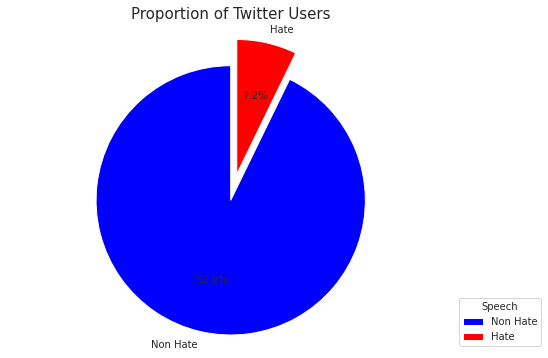

In [14]:
size=data.label.value_counts()
labels='Non Hate', 'Hate'
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(size, explode=(0, 0.2), labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
ax.axis('equal')
plt.title('Proportion of Twitter Users', size=15)
ax.legend(labels, bbox_to_anchor=(1, 0), loc='lower left', title='Speech')
plt.show()

It is given that 7.2% of twitter users might Hate. So the baseline model could be to predict that 7.2% of the users will Hate. Given 7.2% is a small number, we need to ensure that the chosen model does predict with great accuracy this 7.2% as it is of interest to the company to identify these users as opposed to accurately predicting the users that are non haters.

In [15]:
def preprocess_text(text):
    
    """Function to clean text from irrelevant words and symbols"""
    
    if type(text) == float:
        print('Entry not valid')
        return ""
    sentence = []

    # Tokenize and lowercase all alphabet
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(str(text))]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        
        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in stopwords_punctuation:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace('ii', '').replace('iii', '')
    final_sent = final_sent.replace("'s", "").replace("''", "").replace("nt", "not")
    return final_sent

data_cleaned = data.copy()
data_cleaned['cleaned_text'] = data_cleaned.text.apply(preprocess_text)
print(f'The longest for tweet is: {max(data_cleaned.cleaned_text.str.len())}')
print(f'The shortest for tweet is: {min(data_cleaned.cleaned_text.str.len())}')

The longest for tweet is: 521
The shortest for tweet is: 0


# Visualize the frequency of Words

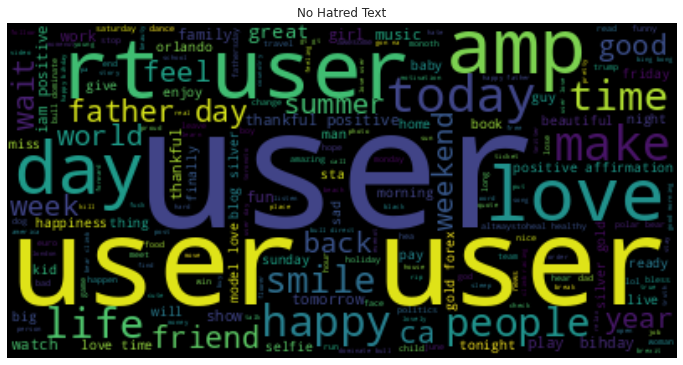

In [16]:
# Let's split the dataset into non hate(0) and hate(1) so as to visualize the frequency of the words
no_hate = data_cleaned[data_cleaned['label']==0]
hate = data_cleaned[data['label']==1]

wordcloud = WordCloud(background_color='black').generate(' '.join(no_hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('No Hatred Text')
plt.axis('off')
plt.show()

**Above, we can see that those are `non-hate` statements**

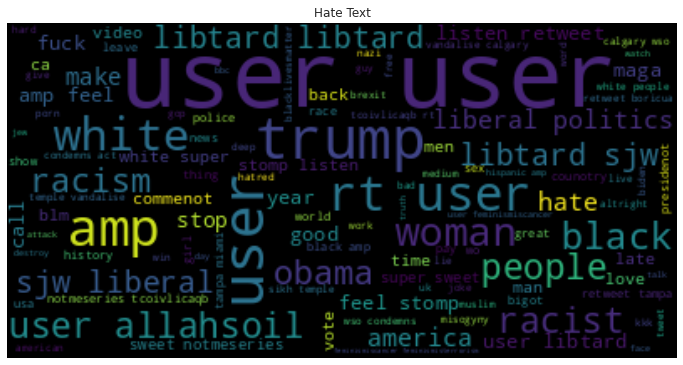

In [17]:
wordcloud = WordCloud(background_color='black').generate(' '.join(hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Text')
plt.axis('off')
plt.show()

**While these are `hate` statements**

# Feature Engineering

## Frequency distribution of Part of Speech Tags

In [18]:
%%time 
pos_group = {
    'noun':['NN','NNS','NNP','NNPS'],
    'pron':['PRP','PRP$','WP','WP$'],
    'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj':['JJ','JJR','JJS'],
    'adv':['RB','RBR','RBS','WRB']
}

        
def count_pos_tag(text, flags):
    
    """Function to check and count the respective parts of speech tags"""
    
    count=0
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    tags = pos_tag(tokens)

    for (token, tag) in tags:
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        if tag in pos_group[flags]:
            count+=1
    return count

data_cleaned['noun_count'] = data_cleaned.text.apply(lambda x: count_pos_tag(x, 'noun'))
data_cleaned['verb_count'] = data_cleaned.text.apply(lambda x: count_pos_tag(x, 'verb'))
data_cleaned['adj_count'] = data_cleaned.text.apply(lambda x: count_pos_tag(x, 'adj'))
data_cleaned['adv_count'] = data_cleaned.text.apply(lambda x: count_pos_tag(x, 'adv'))
data_cleaned['pron_count'] = data_cleaned.text.apply(lambda x: count_pos_tag(x, 'pron'))

CPU times: user 3min 39s, sys: 1.75 s, total: 3min 41s
Wall time: 3min 41s


In [19]:
data_cleaned['char_count'] = data_cleaned.text.apply(len)
data_cleaned['word_count'] = data_cleaned.text.apply(lambda x: len(x.split()))
data_cleaned['uniq_word_count'] = data_cleaned.text.apply(lambda x: len(set(x.split())))
data_cleaned['htag_count'] = data_cleaned.text.apply(lambda x: len(re.findall(r'(#w[A-Za-z0-9]*)', x)))
data_cleaned['stopword_count'] = data_cleaned.text.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
data_cleaned['sent_count'] = data_cleaned.text.apply(lambda x: len(sent_tokenize(x)))
data_cleaned['avg_word_len'] = data_cleaned['char_count']/(data_cleaned['word_count']+1)
data_cleaned['avg_sent_len'] = data_cleaned['word_count']/(data_cleaned['sent_count']+1)
data_cleaned['uniq_vs_words'] = data_cleaned.uniq_word_count/data_cleaned.word_count # Ratio of unique words to the total number of words
data_cleaned['stopwords_vs_words'] = data_cleaned.stopword_count/data_cleaned.word_count
data_cleaned['title_word_count'] = data_cleaned.text.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
data_cleaned['uppercase_count'] = data_cleaned.text.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

# Get train labels from the training sets
dataLabel = data_cleaned.label
data_cleaned.drop(['label','id','text'], axis=1, inplace=True)

## Encoding Text

In [20]:
# We will encode text data using TF-IDF
tfVectorizer.fit(data_cleaned.cleaned_text)
tfidf_feats = tfVectorizer.transform(data_cleaned.cleaned_text).toarray()
tfidf = pd.DataFrame(tfidf_feats, columns=tfVectorizer.get_feature_names())
# Join both DataFrames
data_cleaned = tfidf.merge(data_cleaned, left_index=True, right_index=True)
data_cleaned = data_cleaned.drop(['cleaned_text'], axis=1)

# Check for Missing Values

In [21]:
print(data_cleaned.isnull().sum().sort_values(ascending=False))

accept             0
quote              0
problem            0
product            0
project            0
                  ..
garden             0
gay                0
gbp                0
germany            0
uppercase_count    0
Length: 817, dtype: int64


# Scale & Split the Dataset

In [22]:
scaler = StandardScaler()
scaler.fit(data_cleaned)
scaled = scaler.transform(data_cleaned)

X_train, X_test, y_train, y_test = train_test_split(scaled, dataLabel, stratify = dataLabel, test_size = 0.2, random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28608, 817) (7152, 817) (28608,) (7152,)


# Model Building & Evaluation

## Logistic Regression & Parameter tuning

In [23]:
def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No Hate', 'Predicted: Yes Hate'], yticklabels=['Actual: No Hate', 'Actual: Yes Hate'])

for c in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    logReg = LogisticRegression(solver='liblinear', C=c)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{c}->{auc:.4f}")

0.0001->0.9043
0.001->0.9077
0.01->0.9110
0.1->0.9106
1->0.9069
10->0.9035


In [24]:
for m in [0.01, 0.1, 1]:
    print(f"Inverse of regularization strength {m}")
    
    for tol in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
        logReg = LogisticRegression(solver='liblinear', C=m, tol=tol)
        logReg.fit(X_train, y_train)
        pred = logReg.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, pred)
        print(f"{tol}->{auc:.4f}")
    print()

Inverse of regularization strength 0.01
1e-05->0.9110
0.0001->0.9110
0.001->0.9110
0.01->0.9110
0.1->0.9105
1->0.9083
10->0.8964

Inverse of regularization strength 0.1
1e-05->0.9106
0.0001->0.9106
0.001->0.9106
0.01->0.9106
0.1->0.9105
1->0.9086
10->0.8962

Inverse of regularization strength 1
1e-05->0.9069
0.0001->0.9069
0.001->0.9069
0.01->0.9078
0.1->0.9099
1->0.9086
10->0.8962



In [25]:
for maxIt in [1, 5, 10, 15, 20]:
    logReg = LogisticRegression(solver='liblinear', C=0.01, tol=1e-05, max_iter=maxIt)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{maxIt}->{auc:.4f}")

1->0.8964
5->0.9110
10->0.9110
15->0.9110
20->0.9110


In [26]:
for mClass in ["auto", "ovr"]:
    logReg = LogisticRegression(solver='liblinear', C=0.01, tol=1e-05, max_iter=5, multi_class=mClass)
    logReg.fit(X_train, y_train)
    pred = logReg.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{mClass}->{auc:.4f}")

auto->0.9110
ovr->0.9110


ROC AUC Logistic Regression Score: 0.9110


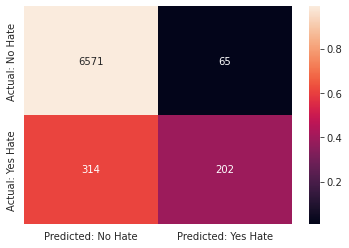

In [27]:
logReg = LogisticRegression(solver='liblinear',
                            C=0.01, tol=1e-05, max_iter=5, 
                            multi_class='auto')

logReg.fit(X_train, y_train)
pred = logReg.predict_proba(X_test)[:, 1]
y_pred = logReg.predict(X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

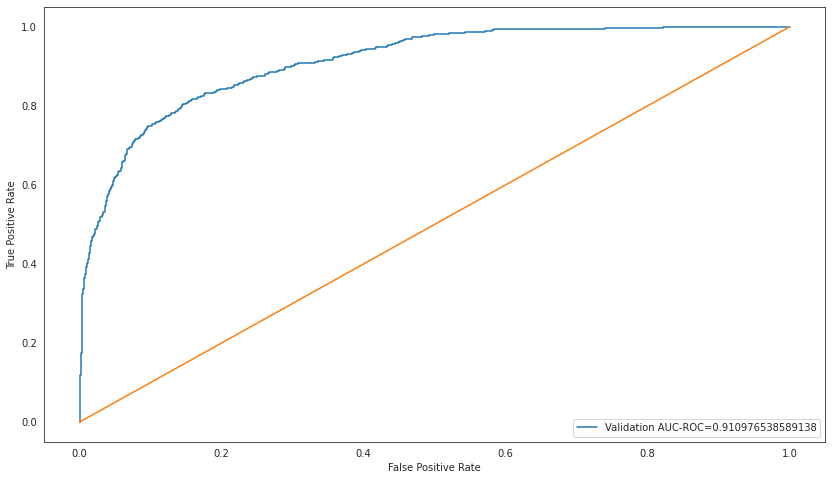

In [28]:
plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

The orange line seen here represents the random selection. What it says is that if i get 50% of the False Positives in my random selection, I also get 50% of the True Positives or True Users that will hate.

## Random Forest & Parameter tuning

In [29]:
for n in [150, 200, 250, 300, 350]:
    rFc = RandomForestClassifier(n_estimators=n, random_state=42)
    rFc.fit(X_train, y_train)
    pred = rFc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

150->0.9211
200->0.9227
250->0.9232
300->0.9234
350->0.9225


In [30]:
del m
del tol
for m in [200, 250, 300]:
    print(f"Number of estimators {m}")
    
    for c in ["gini", "entropy"]:
        rFc = RandomForestClassifier(n_estimators=m, criterion=c, random_state=42)
        rFc.fit(X_train, y_train)
        pred = rFc.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, pred)
        print(f"{c}->{auc:.4f}")
    print()

Number of estimators 200
gini->0.9227
entropy->0.9285

Number of estimators 250
gini->0.9232
entropy->0.9285

Number of estimators 300
gini->0.9234
entropy->0.9286



In [31]:
for depth in [5, 10, 15, None]:
    rFc = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=depth, random_state=42)
    rFc.fit(X_train, y_train)
    pred = rFc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{depth}->{auc:.4f}")

5->0.8693
10->0.8887
15->0.9022
None->0.9286


In [32]:
for samp in [0.01, 0.1, 0.5, 2]:
    rFc = RandomForestClassifier(
        n_estimators=300,
        criterion='entropy', 
        max_depth=None, 
        min_samples_split=samp,
        random_state=42
    )
    
    rFc.fit(X_train, y_train)
    pred = rFc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{samp}->{auc:.4f}")

0.01->0.9213
0.1->0.9027
0.5->0.8635
2->0.9286


In [33]:
for leaf in [0.01, 0.1, 0.5, 2]:
    rFc = RandomForestClassifier(
        n_estimators=300,
        criterion='entropy', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=leaf,
        random_state=42
    )
    
    rFc.fit(X_train, y_train)
    pred = rFc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{leaf}->{auc:.4f}")

0.01->0.7612
0.1->0.6618
0.5->0.5000
2->0.9252


ROC AUC Random Forest Classifier Score: 0.9286
'%' of Misclassified class: 4.991610738255034


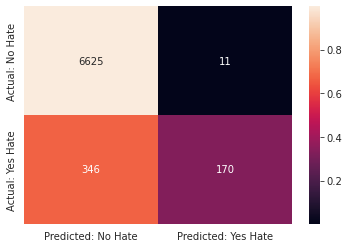

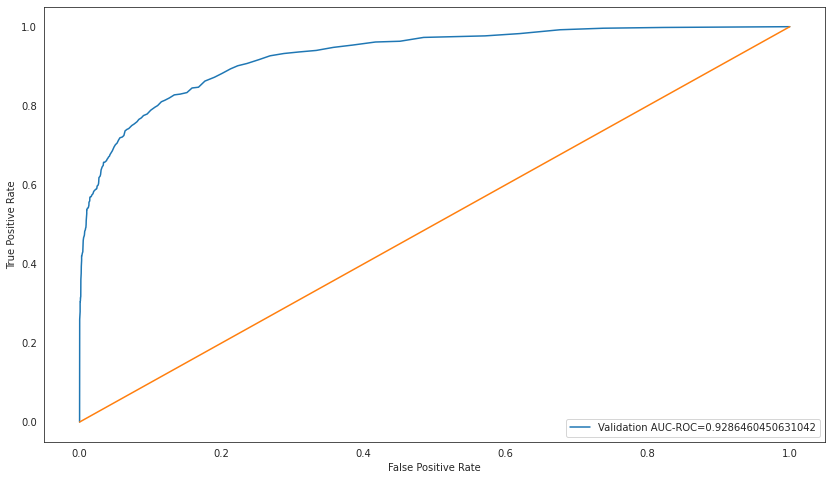

,label,Predicted_class
19709,0,0
9800,0,0
19511,0,0
14545,0,0
12263,0,0
35160,0,0
26656,0,0
14620,0,0
15581,0,0
34607,0,0


In [34]:
rFc = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=None, 
                             min_samples_split=2, random_state=42)
rFc.fit(X_train, y_train)
pred = rFc.predict_proba(X_test)[:, 1]
y_pred = rFc.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Random Forest Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

In [35]:
cols_todisplay = 80
importance_feat = rFc.feature_importances_
sorted_idx = np.argsort(importance_feat)[::-1]

print('These are the most importance Features\n')
for i in range(X_train.shape[1]):
    print(f"{i + 1,cols_todisplay} {data_cleaned.columns[sorted_idx[i]]} ----> {importance_feat[sorted_idx[i]]:.12f}\n")

These are the most importance Features

(1, 80) char_count ----> 0.036217973411

(2, 80) avg_word_len ----> 0.036174185082

(3, 80) user ----> 0.035290972807

(4, 80) trump ----> 0.030148614828

(5, 80) stopwords_vs_words ----> 0.027651510645

(6, 80) avg_sent_len ----> 0.025376574341

(7, 80) white ----> 0.024456000550

(8, 80) noun_count ----> 0.024355838925

(9, 80) uniq_word_count ----> 0.022945636689

(10, 80) word_count ----> 0.022358554462

(11, 80) allahsoil ----> 0.021394917109

(12, 80) stopword_count ----> 0.020254450583

(13, 80) adj_count ----> 0.019082518997

(14, 80) verb_count ----> 0.018729419566

(15, 80) uniq_vs_words ----> 0.018252573127

(16, 80) racist ----> 0.016362267727

(17, 80) adv_count ----> 0.015290484805

(18, 80) amp ----> 0.013227309820

(19, 80) pron_count ----> 0.013045469680

(20, 80) racism ----> 0.012896942837

(21, 80) woman ----> 0.012375932091

(22, 80) black ----> 0.011570948805

(23, 80) sent_count ----> 0.010979642657

(24, 80) not ----> 0.00

In [36]:
rFc_best_feats = data_cleaned[data_cleaned.columns[sorted_idx[:80]]]
rFc_best_feats.head()

,char_count,avg_word_len,user,trump,stopwords_vs_words,avg_sent_len,white,noun_count,uniq_word_count,word_count,allahsoil,stopword_count,adj_count,verb_count,uniq_vs_words,racist,adv_count,amp,pron_count,racism,woman,black,sent_count,not,day,love,commenot,sjw,obama,liberal,libtard,retweet,title_word_count,call,hate,men,fuck,htag_count,act,rt,uppercase_count,race,happy,politics,video,ignore,year,american,no,late,blacklivesmatter,calgary,stop,miami,maga,police,people,make,listen,are,but,america,blm,today,muslim,good,word,presidenot,history,great,life,sex,time,sweet,super,porn,girl,show,brexit,daily
0,158,7.523810,0.0,0.0,0.350000,5.000000,0.0,7,20,20,0.0,7,4,3,1.00000,0.0,0,0.0,1,0.0,0.0,0.0,3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.00000,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,152,9.500000,0.0,0.0,0.000000,7.500000,0.0,8,15,15,0.0,0,5,1,1.00000,0.0,2,0.0,0,0.0,0.0,0.0,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.56508,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,92,5.111111,0.0,0.0,0.352941,5.666667,0.0,4,17,17,0.0,6,2,6,1.00000,0.0,3,0.0,2,0.0,0.0,0.0,2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.00000,0.0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,201,5.025000,0.0,0.0,0.487179,9.750000,0.0,13,29,39,0.0,19,2,8,0.74359,0.0,1,0.0,3,0.0,0.0,0.0,3,0.0,0.134659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.00000,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.257814
4,115,8.214286,0.0,0.0,0.461538,6.500000,0.0,5,13,13,0.0,6,2,2,1.00000,0.0,3,0.0,0,0.0,0.0,0.0,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.00000,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


ROC AUC Random Forest Classifier Score after Feature Selection: 0.9025


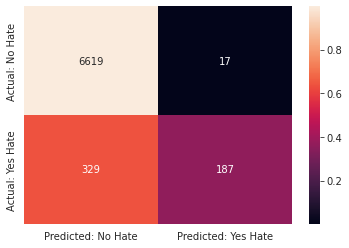

In [37]:
rFc_scaler = StandardScaler()
rFc_scaler.fit(rFc_best_feats)
rFc_scaled = rFc_scaler.transform(rFc_best_feats)

X_train_rFc, X_test_rFc, y_train_rFc, y_test_rFc = train_test_split(rFc_scaled, dataLabel, stratify = dataLabel, test_size = 0.2, random_state = 42)

rFc = RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=None, min_samples_split=2)

rFc.fit(X_train_rFc, y_train_rFc)
pred = rFc.predict_proba(X_test_rFc)[:, 1]
y_pred = rFc.predict(X_test_rFc)
print(f"ROC AUC Random Forest Classifier Score after Feature Selection: {roc_auc_score(y_test_rFc, pred):.4f}")
cm = confusion_matrix(y_test_rFc, y_pred)
confusion_matrix_plot(cm)
plt.show()

**The previous Random Forest Model performed better than the one after Feature Selection**

## Decision Tree & Parameter tuning

In [38]:
del depth
for depth in [5, 10, 15, 20, 25]:
    dTc = DecisionTreeClassifier(random_state=42, max_depth=depth)
    dTc.fit(X_train, y_train)
    pred = dTc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{depth}->{auc:.4f}")

5->0.6550
10->0.6418
15->0.7009
20->0.6829
25->0.6767


In [39]:
del m
del c
for m in [15, 20, 25]:
    print(f"Maximum Depth {m}")
    
    for c in ["gini", "entropy"]:
        dTc = DecisionTreeClassifier(random_state=42, max_depth=m, criterion=c)
        dTc.fit(X_train, y_train)
        pred = dTc.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, pred)
        print(f"{c}->{auc:.4f}")
    print()

Maximum Depth 15
gini->0.7009
entropy->0.7212

Maximum Depth 20
gini->0.6829
entropy->0.7285

Maximum Depth 25
gini->0.6767
entropy->0.7271



In [40]:
for samp in [0.01, 0.1, 0.5, 2]:
    dTc = DecisionTreeClassifier(random_state=42, max_depth=20, criterion='entropy', 
                                 min_samples_split=samp)
    
    dTc.fit(X_train, y_train)
    pred = dTc.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{samp}->{auc:.4f}")

0.01->0.8304
0.1->0.8234
0.5->0.8054
2->0.7285


ROC AUC Decision Tree Classifier Score: 0.8304


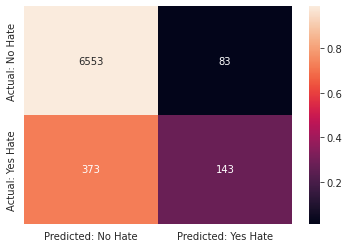

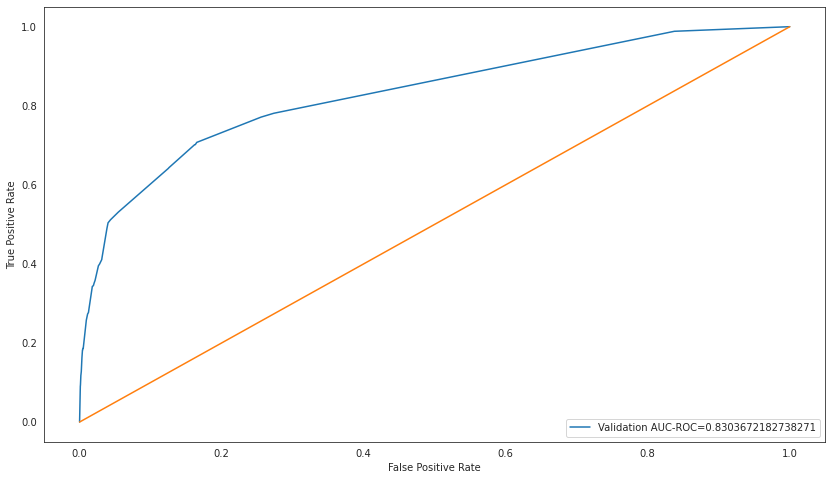

In [41]:
dTc = DecisionTreeClassifier(random_state=42, max_depth=20, criterion='entropy', 
                             min_samples_split=0.01)

dTc.fit(X_train, y_train)
pred = dTc.predict_proba(X_test)[:, 1]
y_pred = dTc.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Decision Tree Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## XGBoost & Parameter tuning

In [42]:
for n in [50, 100, 250, 300]:
    xgb_model = XGBClassifier(n_estimators=n, eval_metric="auc", 
                              objective='binary:logistic')
    
    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

50->0.9139
100->0.9235
250->0.9296
300->0.9283


In [43]:
for lr in [0.1, 1, 1.5]:
    xgb_model = XGBClassifier(n_estimators=250, eval_metric="auc", 
                              objective='binary:logistic', learning_rate=lr)
    
    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, pred)
    print(f"{lr}->{auc:.4f}")

0.1->0.9229
1->0.9048
1.5->0.8645


ROC AUC XGBoost Classifier Score: 0.9296


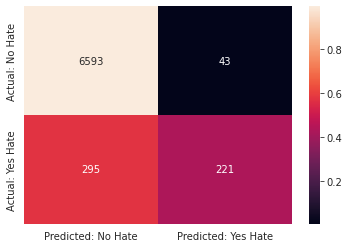

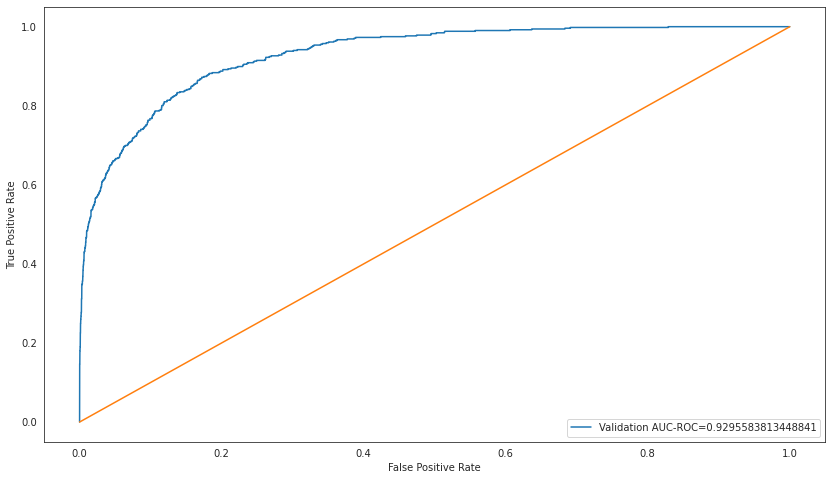

In [44]:
xgb_model = XGBClassifier(n_estimators=250, eval_metric="auc", 
                          objective='binary:logistic')

xgb_model.fit(X_train, y_train)
pred = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

plt.figure(figsize=(14, 8))
fpr, tpr, _ = roc_curve(y_test, pred)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

The XGBoost model has the best performance. We will use cross validation to prevent overfitting and check so we know the actual scores of individual model.

# Model Evaluation with Cross Validation

In [45]:
def cross_validation_score(ml_model, thres = 0.5, random_st=42, cols = data_cleaned.columns):
    
    """
    Function to calculate the k fold cross validation stratified on the basis of target
    and prints the ROC, Recall and Precision Scores.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        thres (float) : threshold for the probabilities of the model predictions
        random_st (int) : random_st is the random state for Kfold
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i= 1
    x1 = data_cleaned.copy()
    x1 = data_cleaned[cols]
    cv_scores = []
    
    sKf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= random_st)
    
    for train_index, test_index in sKf.split(x1, y):
        print(f"\n{i} of KFold {sKf.n_splits}")
        xtrain, xval = x1.iloc[train_index], x1.iloc[test_index]
        ytrain, yval = y.iloc[train_index], y.iloc[test_index]
        
        model = ml_model
        model.fit(xtrain, ytrain)
        y_pred = model.predict(xval)
        pred_probs = model.predict_proba(xval)
        pp = []
        
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
        # Calculate scores for each fold
        pred_val = pp
        roc_score = roc_auc_score(yval, pred_probs[:,1])
        recall = recall_score(yval, pred_val)
        precision = precision_score(yval, pred_val)
        msg = ""
        msg += f"ROC AUC Score: {roc_score:.4f}, Recall Score: {recall:.4f}, Precision Score: {precision:.4f}"
        print(f"{msg}")
        cv_scores.append(roc_score)
        i+=1
        
    return cv_scores

## Logistic Regression

In [46]:
y=dataLabel
log_cv_score = cross_validation_score(LogisticRegression(solver='liblinear',
                                                         C=0.01, tol=1e-05, max_iter=5, multi_class='auto')
                                     )


1 of KFold 5
ROC AUC Score: 0.4261, Recall Score: 0.0000, Precision Score: 0.0000

2 of KFold 5
ROC AUC Score: 0.4582, Recall Score: 0.0000, Precision Score: 0.0000

3 of KFold 5
ROC AUC Score: 0.4507, Recall Score: 0.0000, Precision Score: 0.0000

4 of KFold 5
ROC AUC Score: 0.4667, Recall Score: 0.0000, Precision Score: 0.0000

5 of KFold 5
ROC AUC Score: 0.4546, Recall Score: 0.0000, Precision Score: 0.0000


## RandomForestClassifier

In [47]:
rf_cv_score = cross_validation_score(RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=None, 
                                                            min_samples_split=2, random_state=42)
                                    )


1 of KFold 5
ROC AUC Score: 0.9262, Recall Score: 0.3534, Precision Score: 0.9239

2 of KFold 5
ROC AUC Score: 0.9263, Recall Score: 0.3643, Precision Score: 0.9543

3 of KFold 5
ROC AUC Score: 0.9202, Recall Score: 0.3663, Precision Score: 0.9265

4 of KFold 5
ROC AUC Score: 0.9211, Recall Score: 0.3333, Precision Score: 0.9101

5 of KFold 5
ROC AUC Score: 0.9276, Recall Score: 0.3430, Precision Score: 0.9568


## DecisionTreeClassifier

In [48]:
dt_cv_score = cross_validation_score(DecisionTreeClassifier(random_state=42, max_depth=20, criterion='entropy', 
                                                            min_samples_split=0.01)
                                    )


1 of KFold 5
ROC AUC Score: 0.8266, Recall Score: 0.2544, Precision Score: 0.6684

2 of KFold 5
ROC AUC Score: 0.8335, Recall Score: 0.2791, Precision Score: 0.7273

3 of KFold 5
ROC AUC Score: 0.8272, Recall Score: 0.3023, Precision Score: 0.7324

4 of KFold 5
ROC AUC Score: 0.8067, Recall Score: 0.3314, Precision Score: 0.6759

5 of KFold 5
ROC AUC Score: 0.8179, Recall Score: 0.3217, Precision Score: 0.6336


## XGBClassifier

In [49]:
xgb_cv_score = cross_validation_score(XGBClassifier(n_estimators=250, eval_metric="auc", 
                                                    objective='binary:logistic')
                                     )


1 of KFold 5
ROC AUC Score: 0.9218, Recall Score: 0.4194, Precision Score: 0.7742

2 of KFold 5
ROC AUC Score: 0.9267, Recall Score: 0.4535, Precision Score: 0.8125

3 of KFold 5
ROC AUC Score: 0.9314, Recall Score: 0.4535, Precision Score: 0.8069

4 of KFold 5
ROC AUC Score: 0.9205, Recall Score: 0.4399, Precision Score: 0.8255

5 of KFold 5
ROC AUC Score: 0.9278, Recall Score: 0.4264, Precision Score: 0.8000


# Comparison of Model Fold wise

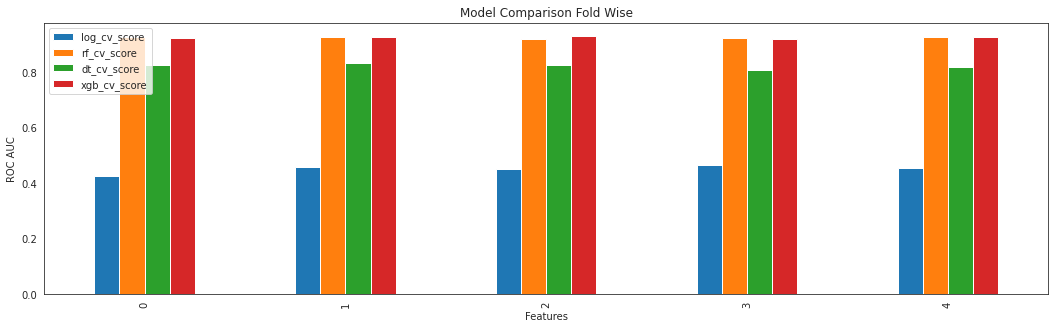

In [50]:
compare_score = pd.DataFrame({'log_cv_score':log_cv_score,
                              'rf_cv_score':rf_cv_score,
                              'dt_cv_score':dt_cv_score,
                              'xgb_cv_score':xgb_cv_score
                             })

compare_score.plot(y = ['log_cv_score','rf_cv_score',
                        'dt_cv_score','xgb_cv_score'], 
                   kind = 'bar')

plt.title('Model Comparison Fold Wise')
plt.xlabel('Features')
plt.ylabel('ROC AUC');

**The `XGBoost Model` has the best performance across 5-fold. Therefore, we will work on improving this model**

# Let's try to reduce the target missclassification

In [51]:
xgb_model = XGBClassifier(n_estimators=250, eval_metric="auc", objective='binary:logistic')
xgb_model.fit(X_train, y_train)

step_factor = 0.05
threshold_value = 0.1
roc_score = 0
proba = xgb_model.predict_proba(X_test)

# Continue to check for optimal value when threshold is
# less than 0.8
while threshold_value <= 0.8:
    temp_thresh = threshold_value
    predicted = (proba[:,1] >= temp_thresh).astype('int')
    print(f"Threshold: {temp_thresh}->{roc_auc_score(y_test, predicted)}")
    #store the threshold for best classification
    if roc_score < roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        threshold_score = threshold_value
    threshold_value = threshold_value + step_factor
print(f'---Optimum Threshold: {threshold_score}->ROC{roc_score}')

Threshold: 0.1->0.8272512861488428
Threshold: 0.15000000000000002->0.8066501254608408
Threshold: 0.2->0.7936309348584886
Threshold: 0.25->0.7740881309839214
Threshold: 0.3->0.7633854100957428
Threshold: 0.35->0.7495496726803762
Threshold: 0.39999999999999997->0.7362308479470682
Threshold: 0.44999999999999996->0.7186488077715631
Threshold: 0.49999999999999994->0.7109073832653461
Threshold: 0.5499999999999999->0.7006252015083337
Threshold: 0.6->0.6893740275032592
Threshold: 0.65->0.6799854913999749
Threshold: 0.7000000000000001->0.66799136492984
Threshold: 0.7500000000000001->0.6546515132399737
---Optimum Threshold: 0.1->ROC0.8272512861488428


In [52]:
rfc_cv_score = cross_validation_score(XGBClassifier(n_estimators=250, eval_metric="auc", 
                                                    objective='binary:logistic'),
                                      thres=0.1)


1 of KFold 5
ROC AUC Score: 0.9218, Recall Score: 0.7495, Precision Score: 0.3979

2 of KFold 5
ROC AUC Score: 0.9267, Recall Score: 0.7442, Precision Score: 0.4038

3 of KFold 5
ROC AUC Score: 0.9314, Recall Score: 0.7519, Precision Score: 0.4050

4 of KFold 5
ROC AUC Score: 0.9205, Recall Score: 0.7326, Precision Score: 0.4004

5 of KFold 5
ROC AUC Score: 0.9278, Recall Score: 0.7539, Precision Score: 0.4303


# Prediction based on probability

ROC AUC XGBoost Classifier Score: 0.9296
XGBoost Recall Score: 0.7461
XGBoost Precision Score: 0.3877
'%' of Misclassified class: 10.332774049217003


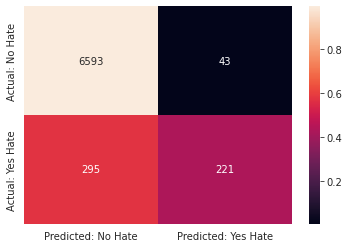

,label,Predicted_class
19709,0,0
9800,0,0
19511,0,0
14545,0,1
12263,0,1
35160,0,0
26656,0,0
14620,0,0
15581,0,0
34607,0,0


In [53]:
thres = 0.1
prediction = []
model = XGBClassifier(n_estimators=250, eval_metric="auc", 
                      objective='binary:logistic')

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 1]

for i in probs:
    if i > thres:
        prediction.append(1)
    else:
        prediction.append(0)
    
roc_score = roc_auc_score(y_test, probs)
recall = recall_score(y_test, prediction)
precision = precision_score(y_test, prediction)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print(f"XGBoost Recall Score: {recall:.4f}")
print(f"XGBoost Precision Score: {precision:.4f}")
print("'%' of Misclassified class:", np.mean(prediction != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = prediction[0:30]
out

We can see a little improvement in the recall score but with a high Misclassified class.

**Ways to improve this model**
1. Add more training data
2. Try Over/Undersampling techniques like SMOTE

# Addressing Imbalanced Class with SMOTE

In [54]:
print(data_cleaned.shape)
print(y.shape)

(35760, 817)
(35760,)


In [55]:
print(y.value_counts())
print(y.value_counts(normalize=True)*100)

0    33181
1     2579
Name: label, dtype: int64
0    92.788031
1     7.211969
Name: label, dtype: float64


In [56]:
smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(data_cleaned, y)
print(y_sm.value_counts())
print(y_sm.value_counts(normalize=True)*100)

0    33181
1    33181
Name: label, dtype: int64
0    50.0
1    50.0
Name: label, dtype: float64


In [57]:
imb_scaler = StandardScaler()
imb_scaler.fit(x_sm)
imb_scaled = scaler.transform(x_sm)
X_train, X_test, y_train, y_test = train_test_split(imb_scaled, y_sm, stratify=y_sm, 
                                                    random_state= 42, test_size= 0.2)

In [ ]:
final_model = XGBClassifier(n_estimators=250, eval_metric="auc", 
                            objective='binary:logistic')

final_model.fit(X_train, y_train)
pred = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)
print(f"ROC AUC XGBoost Score: {roc_auc_score(y_test, pred):.4f}")
print(f"Recall score of XGBoost: {recall_score(y_test, y_pred):.4f}")
print(f"Precision score of XGBoost: {precision_score(y_test, y_pred):.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

# Serialize Tfidf Vectorizer, StandardScaler & the Final Model

In [ ]:
with open('vectorizer.bin', 'wb') as f:
    pickle.dump(tfVectorizer, f)

with open('scaler.bin', 'wb') as f:
    pickle.dump(imb_scaler, f)
    
with open('model.bin', 'wb') as f:
    pickle.dump(final_model, f)